# 250629 Reclassification of mutaiton final

# 1.0 Folding only binding only

## 1.0 Running the calculaiton

=== Folding: Benign Variants (per‐method |abs| + picked max) ===
 position mutation  ddg_imutant2_str  ddg_inps_str  ddg_ddgun_str  ddg_mcsm_str  ddg_ddmut_str  ddG_Fmax
        3      I3F              0.27          0.16            0.0         0.675           0.04     0.675
      240    S240T              0.12          0.20            0.0         0.362           0.07     0.362
      254    H254R              0.24          0.03            0.0         0.027           0.13     0.240
        5      N5D              0.08          0.01            0.0         0.031           0.09     0.090

=== Folding: Pathogenic Variants (per‐method |abs| + picked max) ===
 position mutation  ddg_imutant2_str  ddg_inps_str  ddg_ddgun_str  ddg_mcsm_str  ddg_ddmut_str  ddG_Fmax
       40     A40V              0.86          0.01            0.7         0.111           0.16      0.86
       20     G20V              0.89          0.69            0.1         0.127           0.39      0.89
      178    R178W       

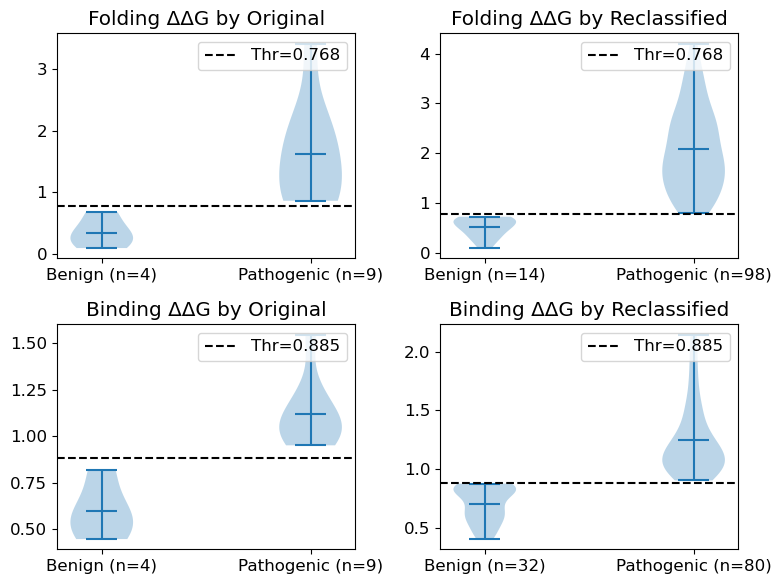

/local_scratch/slurm.3868669/ipykernel_806700/3084620538.py:246: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


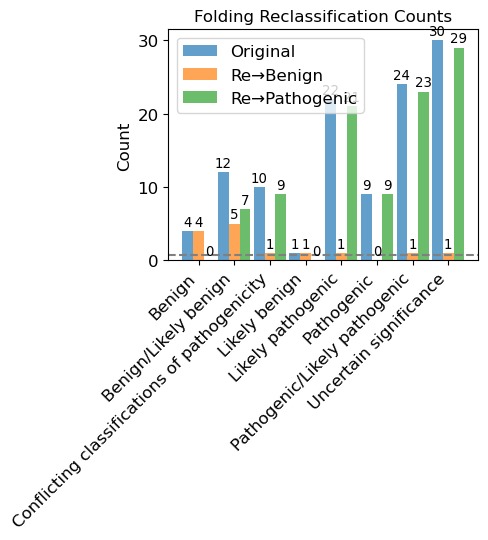

/local_scratch/slurm.3868669/ipykernel_806700/3084620538.py:246: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


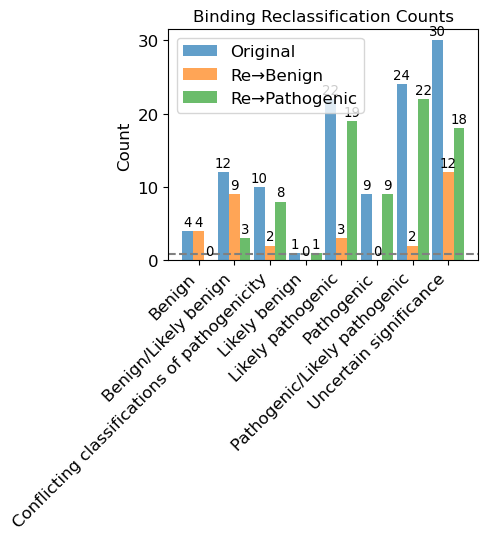

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def plot_ddg_distributions(folding_path, binding_path,
                           fig_width=12, fig_height=10,
                           font_size=12, violin_width=0.7):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    plt.rcParams.update({'font.size': font_size})
    
    # --- 1. Folding dataset processing ---
    df_fold = pd.read_excel(folding_path)
    df_fold = df_fold[df_fold['position'].between(1, 302)]
    str_cols = [c for c in df_fold.columns if c.endswith('_str') and 'foldx' not in c.lower()]
    df_fold['ddG_Fmax'] = df_fold[str_cols].abs().max(axis=1)

    benign_fold = df_fold[df_fold['Germline classification']=='Benign'] \
                      [['position','mutation','ddG_Fmax']].sort_values('ddG_Fmax', ascending=False)
    path_fold   = df_fold[df_fold['Germline classification']=='Pathogenic'] \
                      [['position','mutation','ddG_Fmax']].sort_values('ddG_Fmax', ascending=True)

    max_ben_f = benign_fold.iloc[0]['ddG_Fmax']
    min_pat_f = path_fold.iloc[0]['ddG_Fmax']
    threshold_f = (max_ben_f + min_pat_f) / 2

    # <<< INSERT HERE >>>
    def print_folding_method_breakdown(idx_list, title):
        # build a mini‐table with abs values of each method plus the chosen max
        tbl = df_fold.loc[idx_list, ['position','mutation']].copy()
        # take absolute values for each str_col
        for c in str_cols:
            tbl[c] = df_fold.loc[idx_list, c].abs()
        tbl['ddG_Fmax'] = df_fold.loc[idx_list, 'ddG_Fmax']
        print(f"=== Folding: {title} (per‐method |abs| + picked max) ===")
        print(tbl.to_string(index=False))
        print()

    print_folding_method_breakdown(benign_fold.index, "Benign Variants")
    print_folding_method_breakdown(path_fold.index,   "Pathogenic Variants")
    # <<< END INSERT >>>

    
    
    print("=== Folding: Benign Variants (sorted by ddG_Fmax desc) ===")
    print(benign_fold.to_string(index=False))
    print("\n=== Folding: Pathogenic Variants (sorted by ddG_Fmax asc) ===")
    print(path_fold.to_string(index=False))
    print(f"\nMax benign ddG_Fmax: {max_ben_f:.3f}")
    print(f"Min pathogenic ddG_Fmax: {min_pat_f:.3f}")
    print(f"Folding threshold: {threshold_f:.3f}\n")

    # reclassify uncertain by folding
    df_fold['Reclass_fold'] = df_fold['Germline classification']
    mask_unc_f = ~df_fold['Germline classification'].isin(['Benign','Pathogenic'])
    df_fold.loc[mask_unc_f & (df_fold['ddG_Fmax'] >= threshold_f), 'Reclass_fold'] = 'Pathogenic'
    df_fold.loc[mask_unc_f & (df_fold['ddG_Fmax'] <  threshold_f), 'Reclass_fold'] = 'Benign'

    counts_f = {
        'orig_ben': len(benign_fold),
        'orig_path': len(path_fold),
        'pred_ben': df_fold['Reclass_fold'].value_counts().get('Benign', 0),
        'pred_path': df_fold['Reclass_fold'].value_counts().get('Pathogenic', 0)
    }

    # --- 2. Binding dataset processing ---
    df_bind = pd.read_excel(binding_path)
    df_bind = df_bind[df_bind['position'].between(1, 302)]
    ddg_cols = [c for c in df_bind.columns if c.startswith('ddg_') and '_str_' in c and 'foldx' not in c.lower()]
    partners = ['SOX9','AMPH1','GATAD2A','ZNF219']
    present = [p for p in partners if any(f"_{p}_" in c for c in ddg_cols)]
    for p in present:
        cols = [c for c in ddg_cols if f"_{p}_" in c]
        df_bind[f"ddG_B_{p}"] = df_bind[cols].abs().mean(axis=1)
    partner_cols = [f"ddG_B_{p}" for p in present]
    df_bind['ddG_Bmax'] = df_bind[partner_cols].max(axis=1)

    benign_bind = df_bind[df_bind['Germline classification']=='Benign'] \
                       [['position','mutation','ddG_Bmax']].sort_values('ddG_Bmax', ascending=False)
    path_bind   = df_bind[df_bind['Germline classification']=='Pathogenic'] \
                       [['position','mutation','ddG_Bmax']].sort_values('ddG_Bmax', ascending=True)

    max_ben_b = benign_bind.iloc[0]['ddG_Bmax']
    min_pat_b = path_bind.iloc[0]['ddG_Bmax']
    threshold_b = (max_ben_b + min_pat_b) / 2

    def detailed_table(idx_list, title):
        cols = ['position','mutation','ddG_Bmax'] + partner_cols
        tbl = df_bind.loc[idx_list, cols].copy()
        tbl['Max_partner'] = tbl[partner_cols].idxmax(axis=1).str.replace('ddG_B_','')
        print(f"=== {title}: per-partner breakdown ===")
        print(tbl.to_string(index=False))
        print()

    detailed_table(benign_bind.index,   "Binding: Benign Variants (detailed)")
    detailed_table(path_bind.index,     "Binding: Pathogenic Variants (detailed)")

    
    
    # <<< REVISED INSERT START >>>
    def print_binding_method_breakdown(idx_list, title):
        # build raw table of per-method |ddg| plus avg and overall max
        tbl = df_bind.loc[idx_list, ['position','mutation']].copy()
        for p in present:
            method_cols = [c for c in ddg_cols if f"_{p}_" in c]
            # per-method absolute values
            for c in method_cols:
                tbl[c] = df_bind.loc[idx_list, c].abs()
            # average across methods
            tbl[f"avg_{p}"] = df_bind.loc[idx_list, method_cols].abs().mean(axis=1)
        tbl['ddG_Bmax'] = df_bind.loc[idx_list, 'ddG_Bmax']

        # now shorten column names: ddg_… → Partner_Method, avg_Partner → Partner_avg
        rename_map = {}
        for c in tbl.columns:
            m = re.match(r"ddg_[^_]+_([^_]+)_.*_str_(\w+)$", c)
            if m:
                partner, method = m.groups()
                rename_map[c] = f"{partner}_{method}"
            elif c.startswith("avg_"):
                rename_map[c] = c.replace("avg_", "") + "_avg"
        tbl_short = tbl.rename(columns=rename_map)

        print(f"=== Binding: {title} (per-method |abs| + avg per partner) ===")
        print(tbl_short.to_string(index=False))
        print()

    # call the revised function
    print_binding_method_breakdown(benign_bind.index,   "Benign Variants")
    print_binding_method_breakdown(path_bind.index,     "Pathogenic Variants")
    # <<< REVISED INSERT END >>>


    
    
    print("=== Binding: Benign Variants (sorted by ddG_Bmax desc) ===")
    print(benign_bind.to_string(index=False))
    print("\n=== Binding: Pathogenic Variants (sorted by ddG_Bmax asc) ===")
    print(path_bind.to_string(index=False))
    print(f"\nMax benign ddG_Bmax: {max_ben_b:.3f}")
    print(f"Min pathogenic ddG_Bmax: {min_pat_b:.3f}")
    print(f"Binding threshold: {threshold_b:.3f}\n")

    # reclassify uncertain by binding
    df_bind['Reclass_bind'] = df_bind['Germline classification']
    mask_unc_b = ~df_bind['Germline classification'].isin(['Benign','Pathogenic'])
    df_bind.loc[mask_unc_b & (df_bind['ddG_Bmax'] >= threshold_b), 'Reclass_bind'] = 'Pathogenic'
    df_bind.loc[mask_unc_b & (df_bind['ddG_Bmax'] <  threshold_b), 'Reclass_bind'] = 'Benign'

    counts_b = {
        'orig_ben': len(benign_bind),
        'orig_path': len(path_bind),
        'pred_ben': df_bind['Reclass_bind'].value_counts().get('Benign', 0),
        'pred_path': df_bind['Reclass_bind'].value_counts().get('Pathogenic', 0)
    }

    # --- 3. Plotting 2×2 violin grid ---
    fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height))

    # Folding - original
    axes[0,0].violinplot([benign_fold['ddG_Fmax'], path_fold['ddG_Fmax']],
                         showmeans=True, widths=violin_width)
    axes[0,0].axhline(threshold_f, color='k', linestyle='--', label=f"Thr={threshold_f:.3f}")
    axes[0,0].set_xticks([1,2])
    axes[0,0].set_xticklabels([
        f"Benign (n={counts_f['orig_ben']})",
        f"Pathogenic (n={counts_f['orig_path']})"
    ])
    axes[0,0].set_title("Folding ΔΔG by Original")
    axes[0,0].legend()

    # Folding - reclassified
    axes[0,1].violinplot([df_fold[df_fold['Reclass_fold']=='Benign']['ddG_Fmax'],
                         df_fold[df_fold['Reclass_fold']=='Pathogenic']['ddG_Fmax']],
                        showmeans=True, widths=violin_width)
    axes[0,1].axhline(threshold_f, color='k', linestyle='--', label=f"Thr={threshold_f:.3f}")
    axes[0,1].set_xticks([1,2])
    axes[0,1].set_xticklabels([
        f"Benign (n={counts_f['pred_ben']})",
        f"Pathogenic (n={counts_f['pred_path']})"
    ])
    axes[0,1].set_title("Folding ΔΔG by Reclassified")
    axes[0,1].legend()

    # Binding - original
    axes[1,0].violinplot([benign_bind['ddG_Bmax'], path_bind['ddG_Bmax']],
                         showmeans=True, widths=violin_width)
    axes[1,0].axhline(threshold_b, color='k', linestyle='--', label=f"Thr={threshold_b:.3f}")
    axes[1,0].set_xticks([1,2])
    axes[1,0].set_xticklabels([
        f"Benign (n={counts_b['orig_ben']})",
        f"Pathogenic (n={counts_b['orig_path']})"
    ])
    axes[1,0].set_title("Binding ΔΔG by Original")
    axes[1,0].legend()

    # Binding - reclassified
    axes[1,1].violinplot([df_bind[df_bind['Reclass_bind']=='Benign']['ddG_Bmax'],
                         df_bind[df_bind['Reclass_bind']=='Pathogenic']['ddG_Bmax']],
                        showmeans=True, widths=violin_width)
    axes[1,1].axhline(threshold_b, color='k', linestyle='--', label=f"Thr={threshold_b:.3f}")
    axes[1,1].set_xticks([1,2])
    axes[1,1].set_xticklabels([
        f"Benign (n={counts_b['pred_ben']})",
        f"Pathogenic (n={counts_b['pred_path']})"
    ])
    axes[1,1].set_title("Binding ΔΔG by Reclassified")
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()


        # ── 4. Folding & Binding grouped‐bar reclassification plots ──
    def plot_grouped_reclass(df, orig_label, reclass_col, title, threshold):
        # build contingency
        ct    = pd.crosstab(df[orig_label], df[reclass_col])
        orig  = df[orig_label].value_counts().reindex(ct.index).fillna(0).values
        re_b  = ct.get('Benign',    pd.Series(0, index=ct.index)).values
        re_p  = ct.get('Pathogenic',pd.Series(0, index=ct.index)).values

        x     = np.arange(len(ct.index))
        bw    = 0.3

        fig, ax = plt.subplots(figsize=(fig_width/2, fig_height/2))
        ax.bar(x - bw,     orig, width=bw, label='Original',      alpha=0.7)
        ax.bar(x,          re_b,  width=bw, label='Re→Benign',     alpha=0.7)
        ax.bar(x + bw,     re_p,  width=bw, label='Re→Pathogenic', alpha=0.7)

        ax.set_xticks(x)
        ax.set_xticklabels(ct.index, rotation=45, ha='right', fontsize=font_size)
        ax.set_ylabel("Count", fontsize=font_size)
        ax.set_title(f"{title} Reclassification Counts", fontsize=font_size)
        ax.axhline(threshold, linestyle='--', color='gray')

        ymax = max(orig.max(), re_b.max(), re_p.max())
        for xpos, val in zip(x - bw, orig):
            ax.text(xpos, val + ymax*0.01, int(val), ha='center', va='bottom', fontsize=font_size*0.8)
        for xpos, val in zip(x, re_b):
            ax.text(xpos, val + ymax*0.01, int(val), ha='center', va='bottom', fontsize=font_size*0.8)
        for xpos, val in zip(x + bw, re_p):
            ax.text(xpos, val + ymax*0.01, int(val), ha='center', va='bottom', fontsize=font_size*0.8)

        ax.legend(fontsize=font_size)
        plt.tight_layout()
        plt.show()

    # call for Folding-only
    plot_grouped_reclass(
        df_fold, 
        orig_label    = 'Germline classification',
        reclass_col   = 'Reclass_fold',
        title         = 'Folding',
        threshold     = threshold_f
    )

    # call for Binding-only
    plot_grouped_reclass(
        df_bind, 
        orig_label    = 'Germline classification',
        reclass_col   = 'Reclass_bind',
        title         = 'Binding',
        threshold     = threshold_b
    )

# Example call
plot_ddg_distributions(
    "/project/ealexov/compbio/shamrat/250519_energy/02_folding/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx",
    "/project/ealexov/compbio/shamrat/250519_energy/04_binding/"
    "clinvar_1kgp_hector_gaf_final_binding_znf219_111_only.xlsx",
    fig_width=8, fig_height=6,
    font_size=12, violin_width=0.3
)


## 1.1 Plotting: Folding only binding only

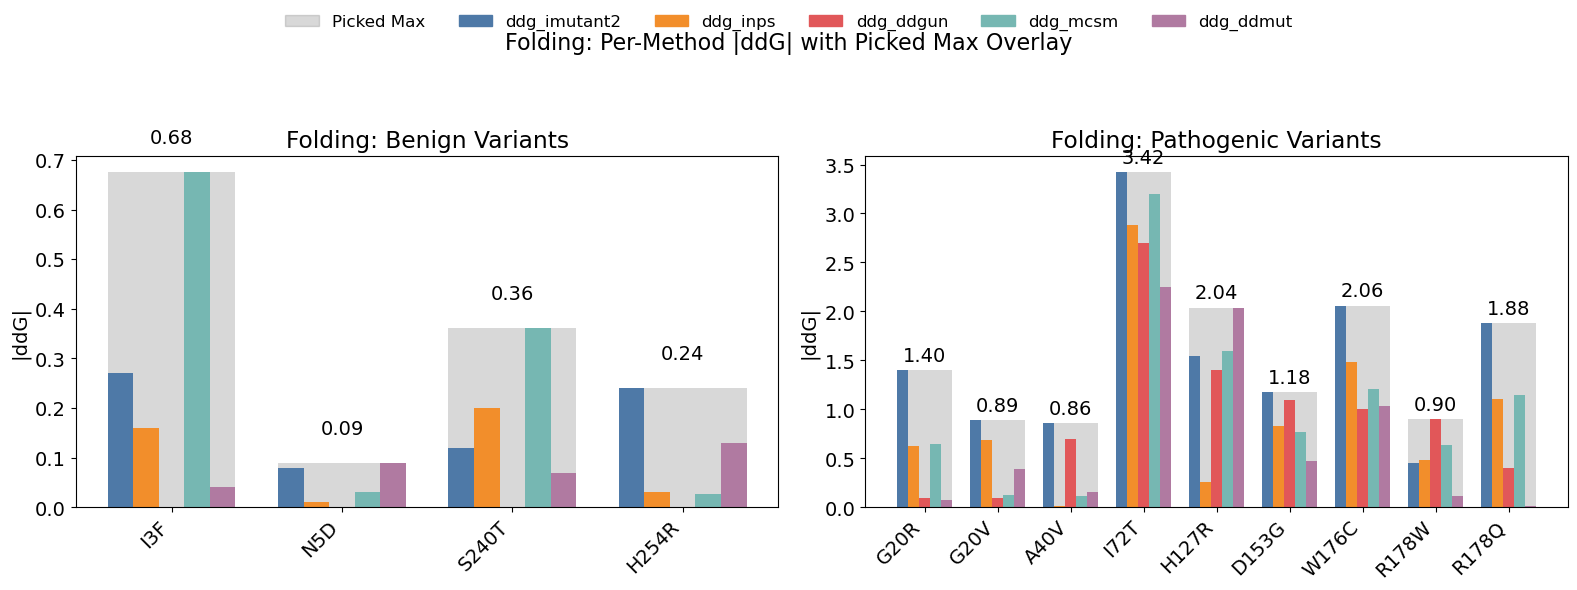

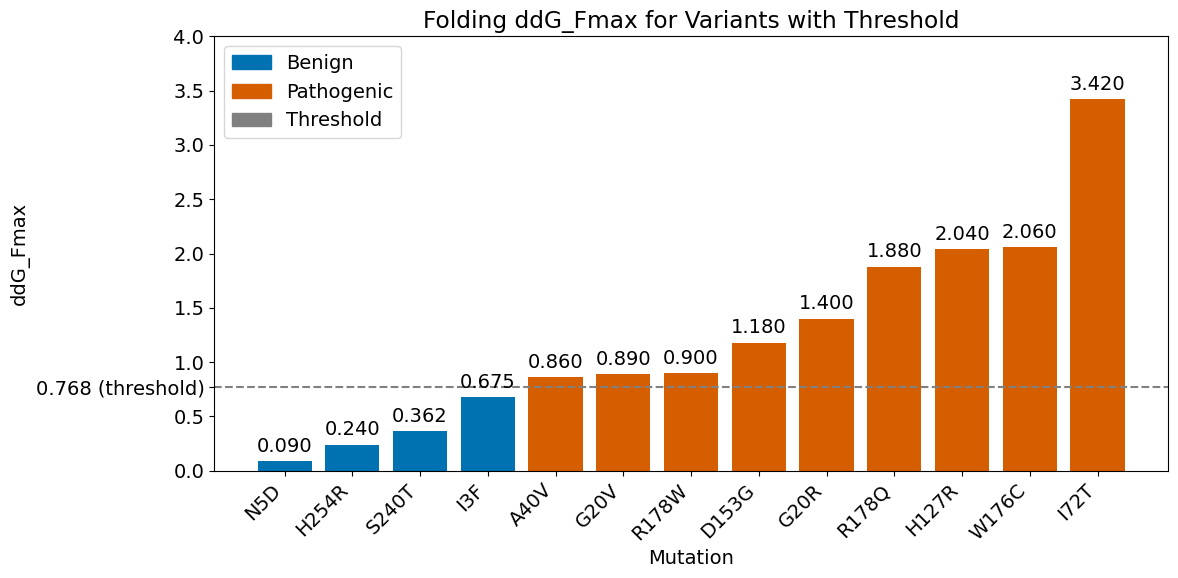

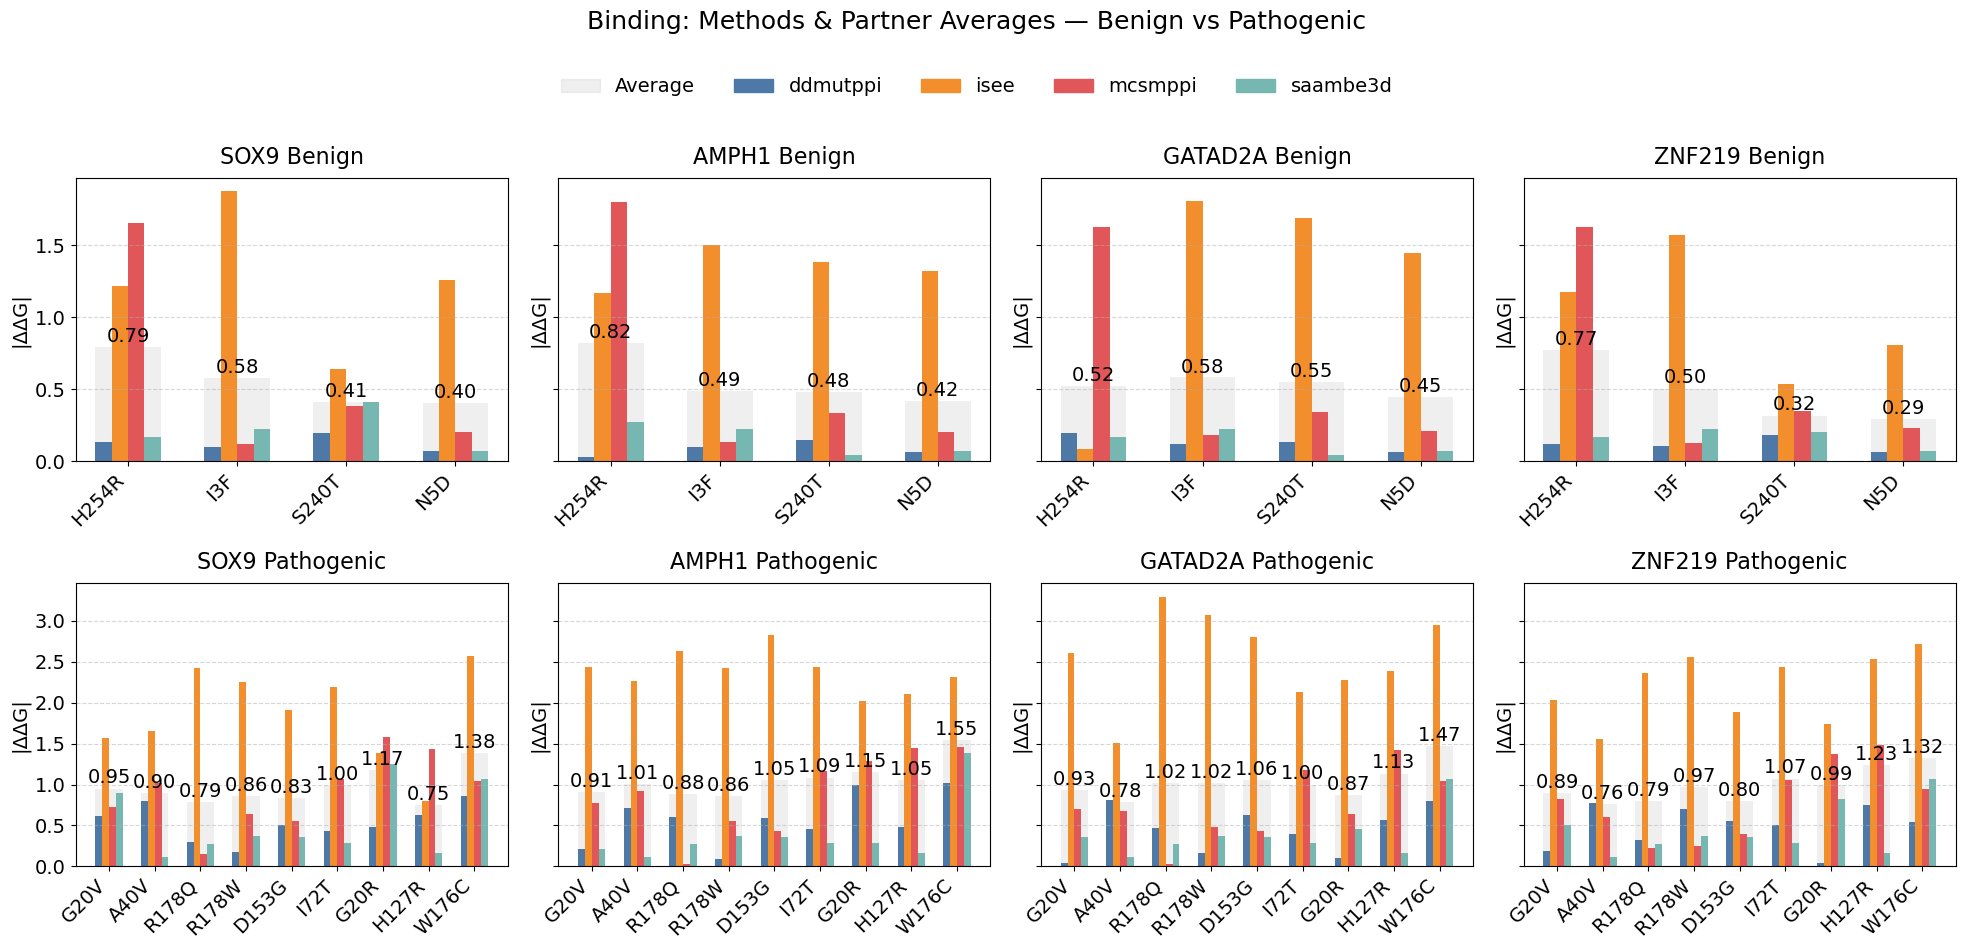

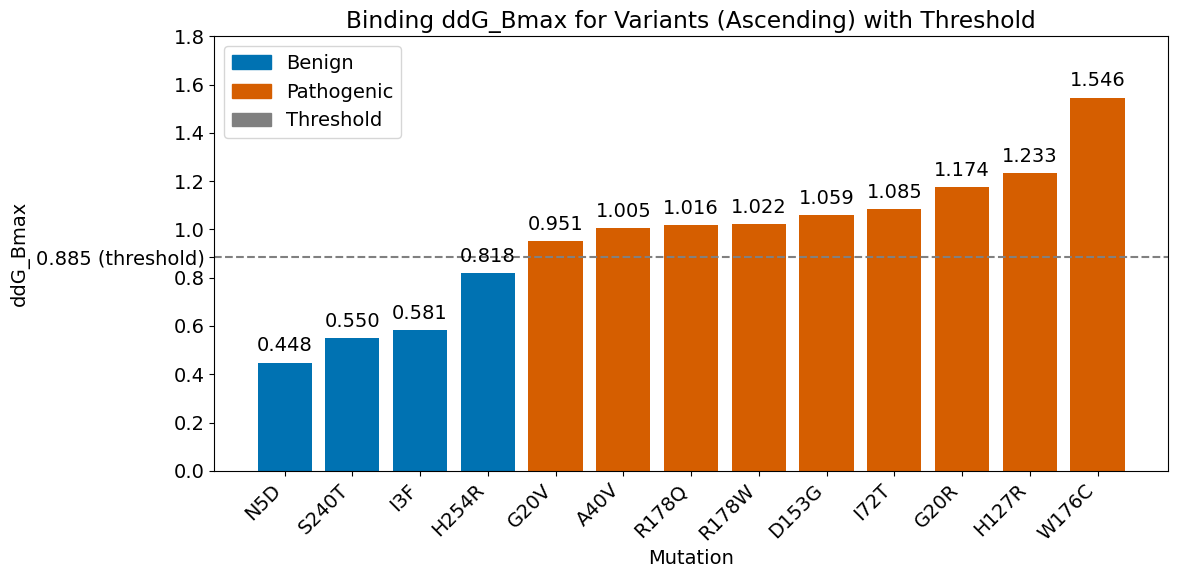

In [18]:
# A) folding per method ddg with picked max
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- User parameters: adjust the Excel path if needed ---
folding_path = "/project/ealexov/compbio/shamrat/250519_energy/02_folding/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"

# Load and filter to positions 1–302
df_fold = pd.read_excel(folding_path)
df_fold = df_fold[df_fold['position'].between(1, 302)]

# Identify per-method columns (exclude FoldX)
str_cols = [c for c in df_fold.columns if c.endswith('_str') and 'foldx' not in c.lower()]

# Compute the max absolute ΔΔG across methods
df_fold['ddG_Fmax'] = df_fold[str_cols].abs().max(axis=1)

# Split into benign and pathogenic
benign_df = df_fold[df_fold['Germline classification'] == 'Benign']
patho_df = df_fold[df_fold['Germline classification'] == 'Pathogenic']

# Build data dicts keyed by mutation, including position and each method's |ddG|
def build_data_dict(subdf):
    data = {}
    for _, row in subdf.iterrows():
        mut = row['mutation']
        entry = {'pos': row['position']}
        for m in str_cols:
            entry[m.replace('_str','')] = abs(row[m])
        # include picked max
        entry['max'] = row['ddG_Fmax']
        data[mut] = entry
    return data

benign_data = build_data_dict(benign_df)
patho_data  = build_data_dict(patho_df)

# Methods list (without '_str' suffix)
methods = [m.replace('_str','') for m in str_cols]
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#B07AA1']
width = 0.15

# Plotting function matching the user style
def plot_side(ax, data, title):
    items = sorted(data.items(), key=lambda kv: kv[1]['pos'])
    variants = [k for k, _ in items]
    x = np.arange(len(variants))
    vals = np.array([[d[m] for m in methods] for _, d in items])
    max_vals = np.array([d['max'] for _, d in items])
    # grey overlay
    ax.bar(x, max_vals, width * len(methods), color='grey', alpha=0.3, zorder=0, label='Picked Max')
    # per-method bars
    for i, m in enumerate(methods):
        ax.bar(x + (i-(len(methods)-1)/2)*width, vals[:, i], width, color=colors[i], zorder=1,
               label=m if ax is plt.gca() and i==0 else "")
    # annotate max
    for xi, y in zip(x, max_vals):
        ax.text(xi, y + 0.05, f'{y:.2f}', ha='center', va='bottom')
    ax.set_xticks(x)
    ax.set_xticklabels(variants, rotation=45, ha='right')
    ax.set_title(title)
    ax.set_ylabel('|ddG|')

# Create figure
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

plot_side(axes[0], benign_data, 'Folding: Benign Variants')
plot_side(axes[1], patho_data,  'Folding: Pathogenic Variants')

# Legend centered above
handles = [plt.Rectangle((0,0),1,1,color='grey', alpha=0.3)] + [plt.Rectangle((0,0),1,1,color=c) for c in colors]
labels = ['Picked Max'] + methods
fig.suptitle('Folding: Per-Method |ddG| with Picked Max Overlay', fontsize=16, y=0.95)
fig.legend(handles, labels, loc='upper center', ncol=len(labels), frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()




## B) Folding ddg_Fmax for variants with threshold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# === 1. Load & filter your folding dataset ===
folding_path = "/project/ealexov/compbio/shamrat/250519_energy/02_folding/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"
df_fold = pd.read_excel(folding_path)
df_fold = df_fold[df_fold['position'].between(1, 302)]

# === 2. Identify per-method columns and compute overall max ΔΔG (ddG_Fmax) ===
str_cols = [c for c in df_fold.columns if c.endswith('_str') and 'foldx' not in c.lower()]
df_fold['ddG_Fmax'] = df_fold[str_cols].abs().max(axis=1)

# === 3. Subset to Benign vs Pathogenic variants ===
sub = df_fold[df_fold['Germline classification'].isin(['Benign', 'Pathogenic'])]
mutations = sub['mutation'].tolist()
ddG_vals   = sub['ddG_Fmax'].tolist()
groups     = sub['Germline classification'].tolist()

# === 4. Sort by ddG_Fmax ascending ===
sorted_idx    = np.argsort(ddG_vals)
mut_sorted    = [mutations[i] for i in sorted_idx]
vals_sorted   = [ddG_vals[i] for i in sorted_idx]
groups_sorted = [groups[i]   for i in sorted_idx]

# === 5. Compute threshold = (max Benign + min Pathogenic) / 2 ===
ben_max = sub[sub['Germline classification']=='Benign']['ddG_Fmax'].max()
pat_min = sub[sub['Germline classification']=='Pathogenic']['ddG_Fmax'].min()
threshold = (ben_max + pat_min) / 2

# === 6. Plotting ===
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12, 6))

# Bar colors by group
color_map = {'Benign': '#0072B2', 'Pathogenic': '#D55E00'}
colors = [color_map[g] for g in groups_sorted]

# Draw bars
bars = ax.bar(mut_sorted, vals_sorted, color=colors)

# Draw threshold line
ax.axhline(threshold, color='gray', linestyle='--')

# Annotate each bar with its ddG_Fmax value
for bar, val in zip(bars, vals_sorted):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        val + 0.05,
        f"{val:.3f}",
        ha='center',
        va='bottom'
    )

# Y‐axis ticks include the threshold
yticks = sorted(set(list(ax.get_yticks()) + [threshold]))
ax.set_yticks(yticks)
ax.set_yticklabels([
    f"{y:.1f}" if y != threshold else f"{threshold:.3f} (threshold)"
    for y in yticks
])

# Legend
legend_handles = [
    Patch(color=color_map['Benign'],    label='Benign'),
    Patch(color=color_map['Pathogenic'],label='Pathogenic'),
    Patch(color='gray',                 label='Threshold')
]
ax.legend(handles=legend_handles, loc='upper left')

# Labels & styling
ax.set_title('Folding ddG_Fmax for Variants with Threshold')
ax.set_xlabel('Mutation')
ax.set_ylabel('ddG_Fmax')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()








## C) Binding methods & Partners Averages (Benign vs Pathogenic)
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# — 0. Uniform font size —
plt.rcParams.update({'font.size': 14})

# — 1. Load & filter your binding data —
binding_path = "/project/ealexov/compbio/shamrat/250519_energy/04_binding/clinvar_1kgp_hector_gaf_final_binding_znf219_111_only.xlsx"
df_bind = pd.read_excel(binding_path)
df_bind = df_bind[df_bind['position'].between(1,302)].copy()

# — 2. Identify raw ddG columns and partners present —
ddg_cols = [c for c in df_bind.columns 
            if c.startswith('ddg_') and '_str_' in c and 'foldx' not in c.lower()]
all_partners = ['SOX9','AMPH1','GATAD2A','ZNF219']
partners = [p for p in all_partners if any(f"_{p}_" in c for c in ddg_cols)]

# — 3. Compute partner averages and overall max —
for p in partners:
    cols = [c for c in ddg_cols if f"_{p}_" in c]
    df_bind[f"avg_{p}"] = df_bind[cols].abs().mean(axis=1)
df_bind['ddG_Bmax'] = df_bind[[f"avg_{p}" for p in partners]].max(axis=1)

# — 4. Build sorted summary tables & variant lists —
benign_bind = (df_bind[df_bind['Germline classification']=='Benign']
               [['position','mutation','ddG_Bmax']]
               .sort_values('ddG_Bmax', ascending=False))
patho_bind = (df_bind[df_bind['Germline classification']=='Pathogenic']
               [['position','mutation','ddG_Bmax']]
               .sort_values('ddG_Bmax', ascending=True))

benign_idx = benign_bind.index
patho_idx  = patho_bind.index
benign_vars = benign_bind['mutation'].tolist()
patho_vars  = patho_bind['mutation'].tolist()

# — 5. Extract method suffixes (the part after "_str_") —
methods = sorted({ re.search(r'_str_(.+)$', c).group(1) 
                   for c in ddg_cols })

# — 6. Plotting colors & bar width —
colors    = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']
avg_color = '#CCCCCC'
width     = 0.15

# — 7. Gather per‐method |ddG| values for benign & pathogenic —
benign_methods = {p: {} for p in partners}
patho_methods  = {p: {} for p in partners}
for p in partners:
    for m in methods:
        # find the one raw column matching this partner+method
        col = [c for c in ddg_cols if f"_{p}_" in c and c.endswith(f"_str_{m}")][0]
        benign_methods[p][m] = df_bind.loc[benign_idx, col].abs().values
        patho_methods[p][m]  = df_bind.loc[patho_idx,  col].abs().values

# — 8. Create a 2×N grid of plots (N = number of partners) —
fig, axes = plt.subplots(2, len(partners), figsize=(20, 10), sharey='row')
for row, (vars_list, methods_dict, grp_label) in enumerate([
    (benign_vars, benign_methods, 'Benign'),
    (patho_vars,  patho_methods,  'Pathogenic')
]):
    for col, p in enumerate(partners):
        ax = axes[row, col]
        x  = np.arange(len(vars_list))
        vals = np.vstack([methods_dict[p][m] for m in methods])
        avg  = vals.mean(axis=0)

        # faded average bar
        ax.bar(x, avg, width*len(methods), color=avg_color, alpha=0.3, zorder=0)
        # per-method bars
        for i, m in enumerate(methods):
            ax.bar(x + (i-(len(methods)-1)/2)*width,
                   vals[i], width, color=colors[i], zorder=1)
        # annotate the average
        for xi, yi in zip(x, avg):
            ax.text(xi, yi + np.nanmax(avg)*0.01,
                    f'{yi:.2f}', ha='center', va='bottom')

        ax.set_xticks(x)
        ax.set_xticklabels(vars_list, rotation=45, ha='right')
        ax.set_ylabel('|ΔΔG|')
        ax.set_title(f'{p} {grp_label}', fontsize=16, pad=10)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

# — 9. Add a supertitle and shared legend —
fig.suptitle('Binding: Methods & Partner Averages — Benign vs Pathogenic', 
             fontsize=18, y=0.95)
handles = ([plt.Rectangle((0,0),1,1,color=avg_color, alpha=0.3)] +
           [plt.Rectangle((0,0),1,1,color=c) for c in colors])
labels  = ['Average'] + methods
fig.legend(handles, labels, loc='upper center', 
           bbox_to_anchor=(0.5,0.90), ncol=len(labels), frameon=False, fontsize=14)

plt.tight_layout(rect=[0,0,1,0.88])
plt.show()








## D) Binding ddG_Bmax for variants with threshold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1. Load & filter the binding dataset
binding_path = "/project/ealexov/compbio/shamrat/250519_energy/04_binding/clinvar_1kgp_hector_gaf_final_binding_znf219_111_only.xlsx"
df = pd.read_excel(binding_path)
df = df[df['position'].between(1, 302)].copy()

# 2. Compute per-partner averages & overall ddG_Bmax if not already present
ddg_cols = [c for c in df.columns if c.startswith('ddg_') and '_str_' in c and 'foldx' not in c.lower()]
partners = ['SOX9','AMPH1','GATAD2A','ZNF219']
for p in partners:
    cols = [c for c in ddg_cols if f"_{p}_" in c]
    if cols:
        df[f"avg_{p}"] = df[cols].abs().mean(axis=1)
df['ddG_Bmax'] = df[[f"avg_{p}" for p in partners if f"avg_{p}" in df]].max(axis=1)

# 3. Build summary DataFrame and sort ascending by ddG_Bmax
ben = (df[df['Germline classification']=='Benign']
       [['mutation','ddG_Bmax']].assign(group='Benign'))
pat = (df[df['Germline classification']=='Pathogenic']
       [['mutation','ddG_Bmax']].assign(group='Pathogenic'))
summary = pd.concat([ben, pat], ignore_index=True)
summary = summary.sort_values('ddG_Bmax', ascending=True).reset_index(drop=True)

# 4. Extract aligned lists for plotting
mutations = summary['mutation'].tolist()
ddG_vals  = summary['ddG_Bmax'].tolist()
groups    = summary['group'].tolist()

# 5. Colors & threshold
color_map = {'Benign':'#0072B2', 'Pathogenic':'#D55E00'}
colors    = [color_map[g] for g in groups]
threshold = (ben['ddG_Bmax'].max() + pat['ddG_Bmax'].min()) / 2

# 6. Create the bar plot
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(mutations, ddG_vals, color=colors)
ax.axhline(threshold, color='gray', linestyle='--')

# Annotate each bar with its value
for bar, val in zip(bars, ddG_vals):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.03,
            f'{val:.3f}', ha='center', va='bottom')

# Y-ticks including the threshold
yticks = sorted(set(list(ax.get_yticks()) + [threshold]))
ax.set_yticks(yticks)
ax.set_yticklabels([
    f'{y:.1f}' if y != threshold else f'{threshold:.3f} (threshold)'
    for y in yticks
])

# Legend
legend_handles = [
    Patch(color=color_map['Benign'],    label='Benign'),
    Patch(color=color_map['Pathogenic'],label='Pathogenic'),
    Patch(color='gray',                 label='Threshold')
]
ax.legend(handles=legend_handles, loc='upper left')

# Titles and labels
ax.set_title('Binding ddG_Bmax for Variants (Ascending) with Threshold')
ax.set_xlabel('Mutation')
ax.set_ylabel('ddG_Bmax')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 1.2 Plotting with save funciton

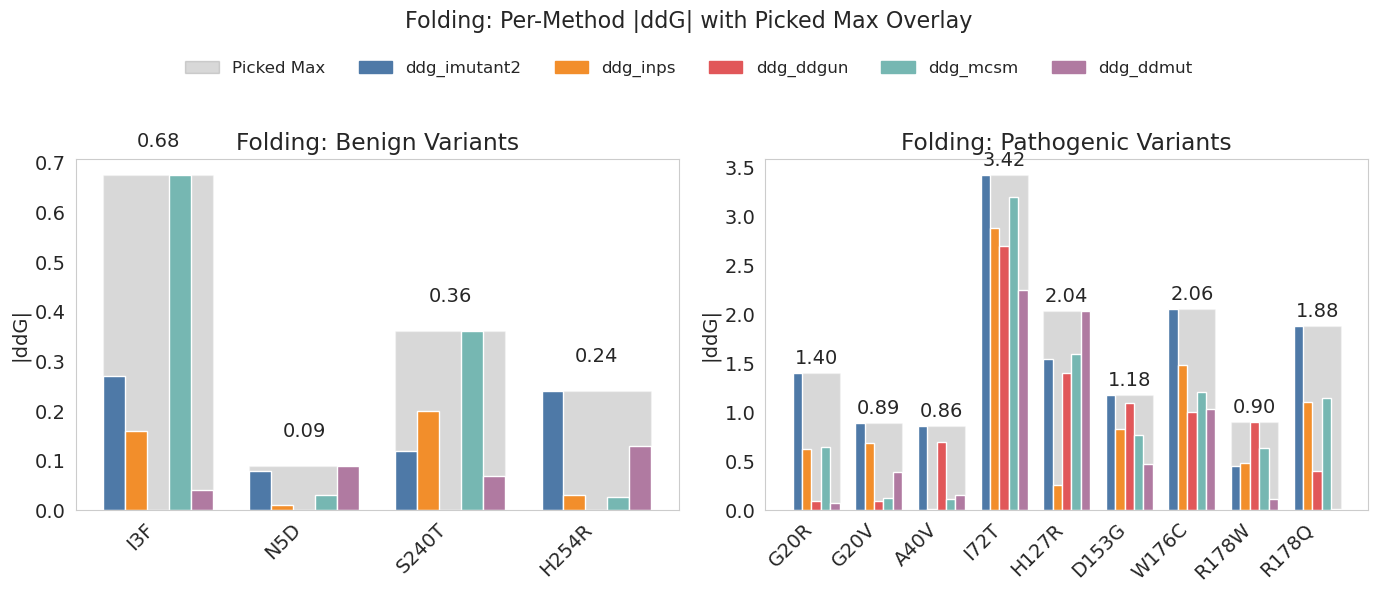

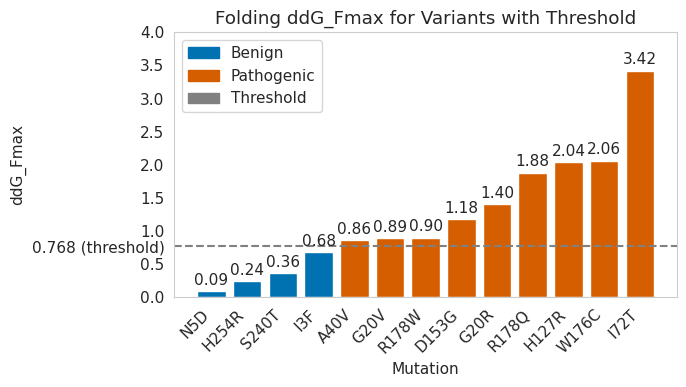

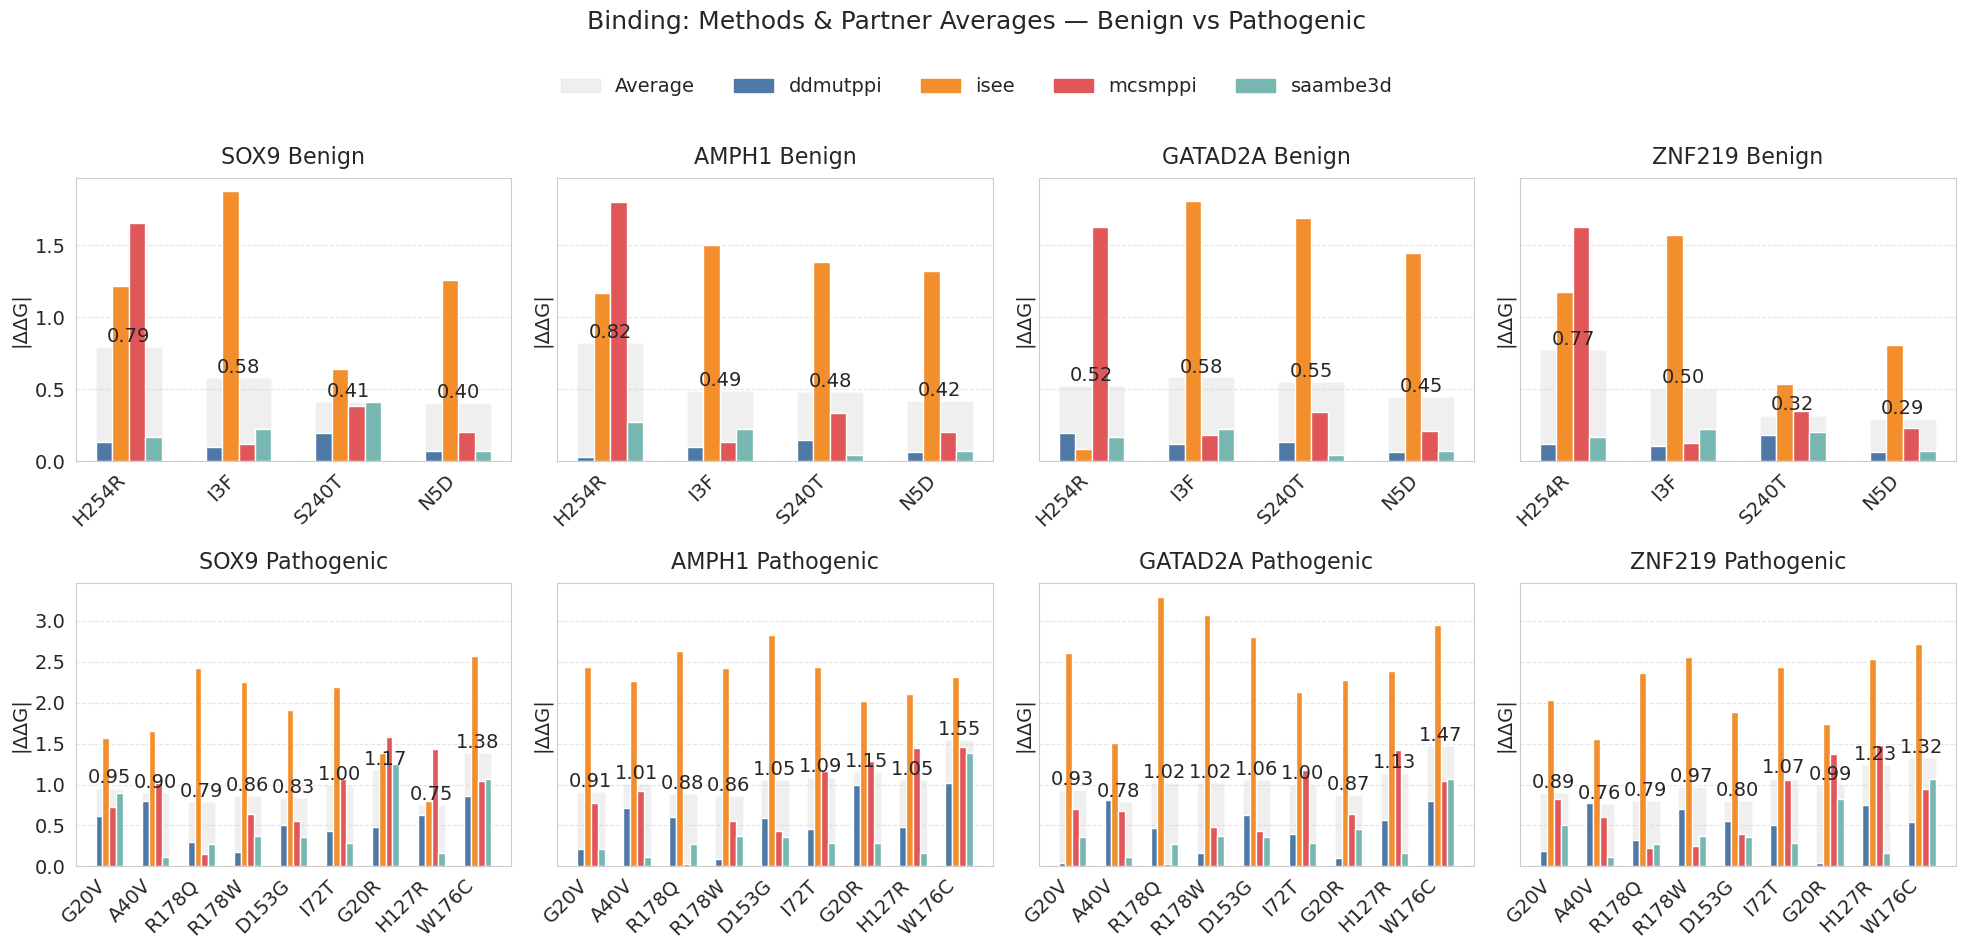

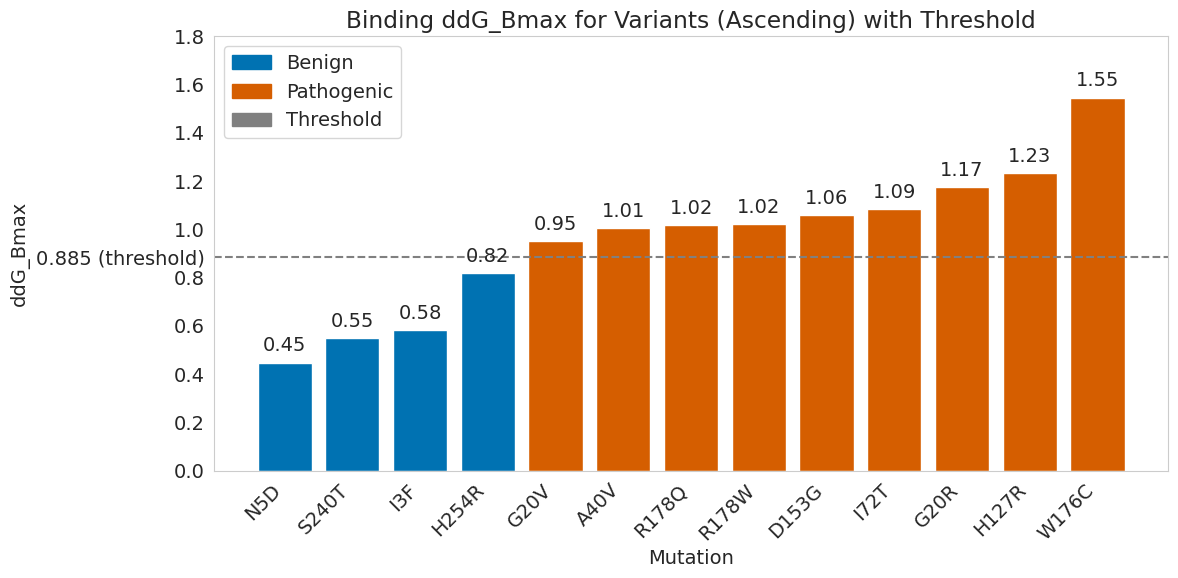

In [267]:
# A) folding per method ddg with picked max
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#Turn of all grids
plt.rcParams.update({'axes.grid': False})

# ← ADDED THESE TWO LINES
output_dir = "/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification"
os.makedirs(output_dir, exist_ok=True)

# --- User parameters: adjust the Excel path if needed ---
folding_path = "/project/ealexov/compbio/shamrat/250519_energy/02_folding/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"



# Load and filter to positions 1–302
df_fold = pd.read_excel(folding_path)
df_fold = df_fold[df_fold['position'].between(1, 302)]

# Identify per-method columns (exclude FoldX)
str_cols = [c for c in df_fold.columns if c.endswith('_str') and 'foldx' not in c.lower()]

# Compute the max absolute ΔΔG across methods
df_fold['ddG_Fmax'] = df_fold[str_cols].abs().max(axis=1)

# Split into benign and pathogenic
benign_df = df_fold[df_fold['Germline classification'] == 'Benign']
patho_df = df_fold[df_fold['Germline classification'] == 'Pathogenic']

# Build data dicts keyed by mutation, including position and each method's |ddG|
def build_data_dict(subdf):
    data = {}
    for _, row in subdf.iterrows():
        mut = row['mutation']
        entry = {'pos': row['position']}
        for m in str_cols:
            entry[m.replace('_str','')] = abs(row[m])
        # include picked max
        entry['max'] = row['ddG_Fmax']
        data[mut] = entry
    return data

benign_data = build_data_dict(benign_df)
patho_data  = build_data_dict(patho_df)

# Methods list (without '_str' suffix)
methods = [m.replace('_str','') for m in str_cols]
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#B07AA1']
width = 0.15

# Plotting function matching the user style
def plot_side(ax, data, title):
    items = sorted(data.items(), key=lambda kv: kv[1]['pos'])
    variants = [k for k, _ in items]
    x = np.arange(len(variants))
    vals = np.array([[d[m] for m in methods] for _, d in items])
    max_vals = np.array([d['max'] for _, d in items])
    # grey overlay
    ax.bar(x, max_vals, width * len(methods), color='grey', alpha=0.3, zorder=0, label='Picked Max')
    # per-method bars
    for i, m in enumerate(methods):
        ax.bar(x + (i-(len(methods)-1)/2)*width, vals[:, i], width, color=colors[i], zorder=1,
               label=m if ax is plt.gca() and i==0 else "")
    # annotate max
    for xi, y in zip(x, max_vals):
        ax.text(xi, y + 0.05, f'{y:.2f}', ha='center', va='bottom')
    ax.set_xticks(x)
    ax.set_xticklabels(variants, rotation=45, ha='right')
    ax.set_title(title)
    ax.set_ylabel('|ddG|')

# Create figure
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

plot_side(axes[0], benign_data, 'Folding: Benign Variants')
plot_side(axes[1], patho_data,  'Folding: Pathogenic Variants')

# Legend centered above
handles = [plt.Rectangle((0,0),1,1,color='grey', alpha=0.3)] + [plt.Rectangle((0,0),1,1,color=c) for c in colors]
labels = ['Picked Max'] + methods
fig.suptitle('Folding: Per-Method |ddG| with Picked Max Overlay', fontsize=16, y=0.99, va='top')
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=len(labels), frameon=False, fontsize=12)


plt.tight_layout(rect=[0, 0, 1, 0.90])
# ← ADDED THIS LINE:
plt.savefig(os.path.join(output_dir, "folding_per_method_ddg_max.png"), dpi=300, bbox_inches='tight')
plt.show()











## B) Folding ddg_Fmax for variants with threshold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

output_dir = "/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification"
os.makedirs(output_dir, exist_ok=True)

# === 1. Load & filter your folding dataset ===
folding_path = "/project/ealexov/compbio/shamrat/250519_energy/02_folding/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"
df_fold = pd.read_excel(folding_path)
df_fold = df_fold[df_fold['position'].between(1, 302)]

# === 2. Identify per-method columns and compute overall max ΔΔG (ddG_Fmax) ===
str_cols = [c for c in df_fold.columns if c.endswith('_str') and 'foldx' not in c.lower()]
df_fold['ddG_Fmax'] = df_fold[str_cols].abs().max(axis=1)

# === 3. Subset to Benign vs Pathogenic variants ===
sub = df_fold[df_fold['Germline classification'].isin(['Benign', 'Pathogenic'])]
mutations = sub['mutation'].tolist()
ddG_vals   = sub['ddG_Fmax'].tolist()
groups     = sub['Germline classification'].tolist()

# === 4. Sort by ddG_Fmax ascending ===
sorted_idx    = np.argsort(ddG_vals)
mut_sorted    = [mutations[i] for i in sorted_idx]
vals_sorted   = [ddG_vals[i] for i in sorted_idx]
groups_sorted = [groups[i]   for i in sorted_idx]

# === 5. Compute threshold = (max Benign + min Pathogenic) / 2 ===
ben_max = sub[sub['Germline classification']=='Benign']['ddG_Fmax'].max()
pat_min = sub[sub['Germline classification']=='Pathogenic']['ddG_Fmax'].min()
threshold = (ben_max + pat_min) / 2

# === 6. Plotting ===
plt.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(figsize=(7, 4))

# Bar colors by group
color_map = {'Benign': '#0072B2', 'Pathogenic': '#D55E00'}
colors = [color_map[g] for g in groups_sorted]

# Draw bars
bars = ax.bar(mut_sorted, vals_sorted, color=colors)

# Draw threshold line
ax.axhline(threshold, color='gray', linestyle='--')

# Annotate each bar with its ddG_Fmax value
for bar, val in zip(bars, vals_sorted):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        val + 0.05,
        f"{val:.2f}",
        ha='center',
        va='bottom'
    )

# Y‐axis ticks include the threshold
yticks = sorted(set(list(ax.get_yticks()) + [threshold]))
ax.set_yticks(yticks)
ax.set_yticklabels([
    f"{y:.1f}" if y != threshold else f"{threshold:.3f} (threshold)"
    for y in yticks
])

# Legend
legend_handles = [
    Patch(color=color_map['Benign'],    label='Benign'),
    Patch(color=color_map['Pathogenic'],label='Pathogenic'),
    Patch(color='gray',                 label='Threshold')
]
ax.legend(handles=legend_handles, loc='upper left')

# Labels & styling
ax.set_title('Folding ddG_Fmax for Variants with Threshold')
ax.set_xlabel('Mutation')
ax.set_ylabel('ddG_Fmax')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "folding_ddg_fmax_threshold.png"), dpi=300, bbox_inches='tight')
plt.show()






## C) Binding methods & Partners Averages (Benign vs Pathogenic)
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ← ADD:
output_dir = "/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification"
os.makedirs(output_dir, exist_ok=True)

# — 0. Uniform font size —
plt.rcParams.update({'font.size': 14})

# — 1. Load & filter your binding data —
binding_path = "/project/ealexov/compbio/shamrat/250519_energy/04_binding/clinvar_1kgp_hector_gaf_final_binding_znf219_111_only.xlsx"
df_bind = pd.read_excel(binding_path)
df_bind = df_bind[df_bind['position'].between(1,302)].copy()

# — 2. Identify raw ddG columns and partners present —
ddg_cols = [c for c in df_bind.columns 
            if c.startswith('ddg_') and '_str_' in c and 'foldx' not in c.lower()]
all_partners = ['SOX9','AMPH1','GATAD2A','ZNF219']
partners = [p for p in all_partners if any(f"_{p}_" in c for c in ddg_cols)]

# — 3. Compute partner averages and overall max —
for p in partners:
    cols = [c for c in ddg_cols if f"_{p}_" in c]
    df_bind[f"avg_{p}"] = df_bind[cols].abs().mean(axis=1)
df_bind['ddG_Bmax'] = df_bind[[f"avg_{p}" for p in partners]].max(axis=1)

# — 4. Build sorted summary tables & variant lists —
benign_bind = (df_bind[df_bind['Germline classification']=='Benign']
               [['position','mutation','ddG_Bmax']]
               .sort_values('ddG_Bmax', ascending=False))
patho_bind = (df_bind[df_bind['Germline classification']=='Pathogenic']
               [['position','mutation','ddG_Bmax']]
               .sort_values('ddG_Bmax', ascending=True))

benign_idx = benign_bind.index
patho_idx  = patho_bind.index
benign_vars = benign_bind['mutation'].tolist()
patho_vars  = patho_bind['mutation'].tolist()

# — 5. Extract method suffixes (the part after "_str_") —
methods = sorted({ re.search(r'_str_(.+)$', c).group(1) 
                   for c in ddg_cols })

# — 6. Plotting colors & bar width —
colors    = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']
avg_color = '#CCCCCC'
width     = 0.15

# — 7. Gather per‐method |ddG| values for benign & pathogenic —
benign_methods = {p: {} for p in partners}
patho_methods  = {p: {} for p in partners}
for p in partners:
    for m in methods:
        # find the one raw column matching this partner+method
        col = [c for c in ddg_cols if f"_{p}_" in c and c.endswith(f"_str_{m}")][0]
        benign_methods[p][m] = df_bind.loc[benign_idx, col].abs().values
        patho_methods[p][m]  = df_bind.loc[patho_idx,  col].abs().values

# — 8. Create a 2×N grid of plots (N = number of partners) —
fig, axes = plt.subplots(2, len(partners), figsize=(20, 10), sharey='row')
for row, (vars_list, methods_dict, grp_label) in enumerate([
    (benign_vars, benign_methods, 'Benign'),
    (patho_vars,  patho_methods,  'Pathogenic')
]):
    for col, p in enumerate(partners):
        ax = axes[row, col]
        x  = np.arange(len(vars_list))
        vals = np.vstack([methods_dict[p][m] for m in methods])
        avg  = vals.mean(axis=0)

        # faded average bar
        ax.bar(x, avg, width*len(methods), color=avg_color, alpha=0.3, zorder=0)
        # per-method bars
        for i, m in enumerate(methods):
            ax.bar(x + (i-(len(methods)-1)/2)*width,
                   vals[i], width, color=colors[i], zorder=1)
        # annotate the average
        for xi, yi in zip(x, avg):
            ax.text(xi, yi + np.nanmax(avg)*0.01,
                    f'{yi:.2f}', ha='center', va='bottom')

        ax.set_xticks(x)
        ax.set_xticklabels(vars_list, rotation=45, ha='right')
        ax.set_ylabel('|ΔΔG|')
        ax.set_title(f'{p} {grp_label}', fontsize=16, pad=10)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

# — 9. Add a supertitle and shared legend —
fig.suptitle('Binding: Methods & Partner Averages — Benign vs Pathogenic', 
             fontsize=18, y=0.95)
handles = ([plt.Rectangle((0,0),1,1,color=avg_color, alpha=0.3)] +
           [plt.Rectangle((0,0),1,1,color=c) for c in colors])
labels  = ['Average'] + methods
fig.legend(handles, labels, loc='upper center', 
           bbox_to_anchor=(0.5,0.90), ncol=len(labels), frameon=False, fontsize=14)

plt.tight_layout(rect=[0,0,1,0.88])
# ← ADD:
plt.savefig(os.path.join(output_dir, "binding_methods_partner_averages.png"), dpi=300, bbox_inches='tight')
plt.show()






## D) Binding ddG_Bmax for variants with threshold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# ← ADD:
output_dir = "/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification"
os.makedirs(output_dir, exist_ok=True)

# 1. Load & filter the binding dataset
binding_path = "/project/ealexov/compbio/shamrat/250519_energy/04_binding/clinvar_1kgp_hector_gaf_final_binding_znf219_111_only.xlsx"
df = pd.read_excel(binding_path)
df = df[df['position'].between(1, 302)].copy()

# 2. Compute per-partner averages & overall ddG_Bmax if not already present
ddg_cols = [c for c in df.columns if c.startswith('ddg_') and '_str_' in c and 'foldx' not in c.lower()]
partners = ['SOX9','AMPH1','GATAD2A','ZNF219']
for p in partners:
    cols = [c for c in ddg_cols if f"_{p}_" in c]
    if cols:
        df[f"avg_{p}"] = df[cols].abs().mean(axis=1)
df['ddG_Bmax'] = df[[f"avg_{p}" for p in partners if f"avg_{p}" in df]].max(axis=1)

# 3. Build summary DataFrame and sort ascending by ddG_Bmax
ben = (df[df['Germline classification']=='Benign']
       [['mutation','ddG_Bmax']].assign(group='Benign'))
pat = (df[df['Germline classification']=='Pathogenic']
       [['mutation','ddG_Bmax']].assign(group='Pathogenic'))
summary = pd.concat([ben, pat], ignore_index=True)
summary = summary.sort_values('ddG_Bmax', ascending=True).reset_index(drop=True)

# 4. Extract aligned lists for plotting
mutations = summary['mutation'].tolist()
ddG_vals  = summary['ddG_Bmax'].tolist()
groups    = summary['group'].tolist()

# 5. Colors & threshold
color_map = {'Benign':'#0072B2', 'Pathogenic':'#D55E00'}
colors    = [color_map[g] for g in groups]
threshold = (ben['ddG_Bmax'].max() + pat['ddG_Bmax'].min()) / 2

# 6. Create the bar plot
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(mutations, ddG_vals, color=colors)
ax.axhline(threshold, color='gray', linestyle='--')

# Annotate each bar with its value
for bar, val in zip(bars, ddG_vals):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.03,
            f'{val:.2f}', ha='center', va='bottom')

# Y-ticks including the threshold
yticks = sorted(set(list(ax.get_yticks()) + [threshold]))
ax.set_yticks(yticks)
ax.set_yticklabels([
    f'{y:.1f}' if y != threshold else f'{threshold:.3f} (threshold)'
    for y in yticks
])

# Legend
legend_handles = [
    Patch(color=color_map['Benign'],    label='Benign'),
    Patch(color=color_map['Pathogenic'],label='Pathogenic'),
    Patch(color='gray',                 label='Threshold')
]
ax.legend(handles=legend_handles, loc='upper left')

# Titles and labels
ax.set_title('Binding ddG_Bmax for Variants (Ascending) with Threshold')
ax.set_xlabel('Mutation')
ax.set_ylabel('ddG_Bmax')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# ← ADD:
plt.savefig(os.path.join(output_dir, "binding_ddg_Bmax_threshold.png"), dpi=300, bbox_inches='tight')
plt.show()


# 250710: Threshold Plot: manuscript

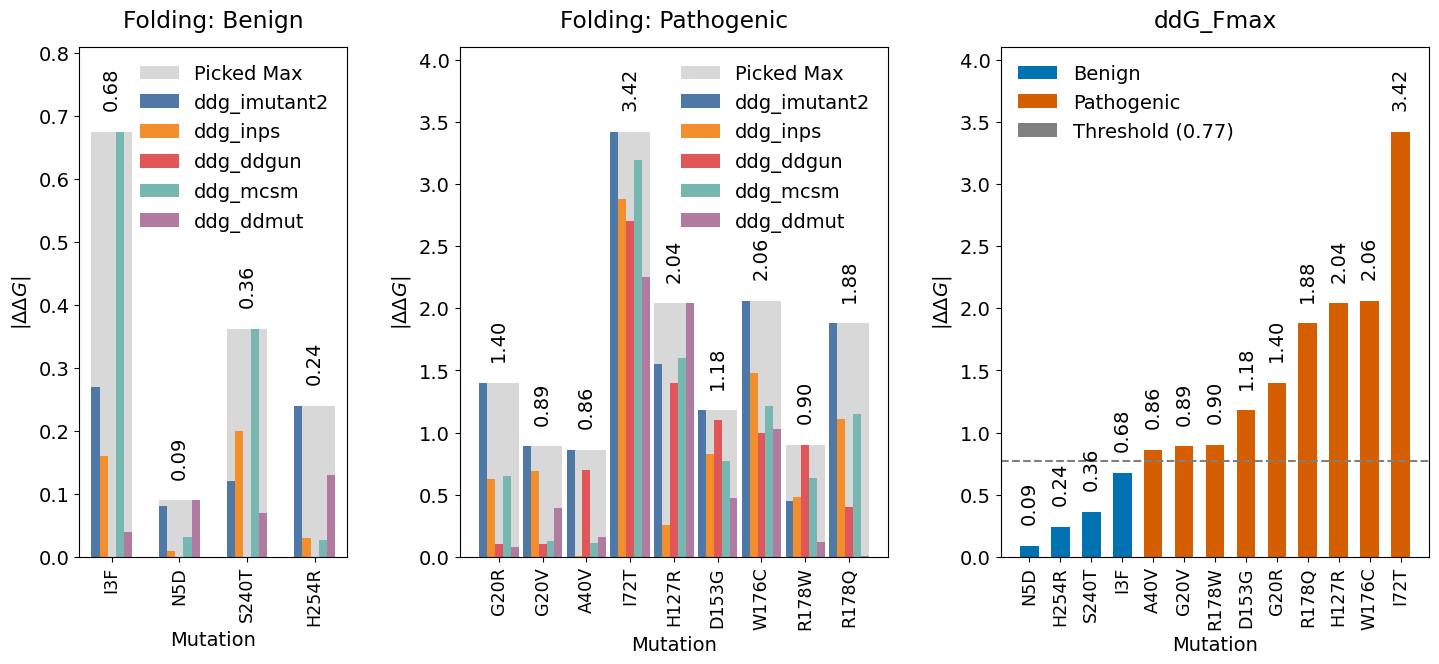

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ─── Setup ───────────────────────────────────────────────────────────────────
output_dir = "/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification"
os.makedirs(output_dir, exist_ok=True)

# ─── Data loading & preprocessing ─────────────────────────────────────────────
folding_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/02_folding/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"
)
df = pd.read_excel(folding_path)
df = df[df['position'].between(1, 302)]

# Structure‐based ΔΔG cols (exclude FoldX) + max
str_cols = [c for c in df.columns if c.endswith('_str') and 'foldx' not in c.lower()]
df['ddG_Fmax'] = df[str_cols].abs().max(axis=1)

# Split into benign/pathogenic dicts
ben_data  = {
    r['mutation']: {
        'pos': r['position'],
        **{c.replace('_str',''): abs(r[c]) for c in str_cols},
        'max': r['ddG_Fmax']
    }
    for _,r in df[df['Germline classification']=='Benign'].iterrows()
}
path_data = {
    r['mutation']: {
        'pos': r['position'],
        **{c.replace('_str',''): abs(r[c]) for c in str_cols},
        'max': r['ddG_Fmax']
    }
    for _,r in df[df['Germline classification']=='Pathogenic'].iterrows()
}

methods = [c.replace('_str','') for c in str_cols]
colors  = ['#4E79A7','#F28E2B','#E15759','#76B7B2','#B07AA1']

# ─── Plot functions with adjustable bar_width ──────────────────────────────────
def annotate_bars(ax, xs, heights, cfg):
    top = max(heights)
    for x, h in zip(xs, heights):
        ax.text(
            x, h + top*cfg.annot_offset, f"{h:.2f}",
            ha='center', va='bottom', rotation=90,
            clip_on=False, fontsize=cfg.annot_fontsize
        )

def finalize_axes(ax, ytops, cfg):
    ax.set_ylim(0, max(ytops)*cfg.y_headroom)
    ax.tick_params(axis='x', labelsize=cfg.base_fontsize*0.9)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')
    ax.grid(False)

def plot_bar_panel(ax, data, title, cfg, bar_width=None):
    w = bar_width if bar_width is not None else cfg.bar_width
    items = sorted(data.items(), key=lambda x: x[1]['pos'])
    muts = [m for m,_ in items]
    x    = np.arange(len(muts))
    vals = np.array([[d[m] for m in methods] for _,d in items])
    maxv = np.array([d['max'] for _,d in items])

    ax.bar(x, maxv, w*len(methods), color='grey', alpha=cfg.bar_alpha)
    for i in range(len(methods)):
        ax.bar(
            x + (i-(len(methods)-1)/2)*w,
            vals[:,i],
            w,
            color=colors[i]
        )

    annotate_bars(ax, x, maxv, cfg)
    ax.set_xticks(x)
    ax.set_xticklabels(muts)
    ax.set_xlabel('Mutation')              # <-- added x-axis label here
    ax.set_ylabel(r'$|\Delta\Delta G|$')
    ax.set_title(title, loc='center', pad=cfg.title_pad)
    handles = [Patch(facecolor='grey', alpha=cfg.bar_alpha, label='Picked Max')] + [
        Patch(facecolor=colors[i], label=methods[i]) for i in range(len(methods))
    ]
    ax.legend(handles, [h.get_label() for h in handles],
              loc='upper right', frameon=False, fontsize=cfg.legend_fontsize)
    finalize_axes(ax, list(maxv), cfg)

def plot_threshold_panel(ax, cfg, bar_width=None):
    w = bar_width if bar_width is not None else cfg.bar_width
    sub = df[df['Germline classification'].isin(['Benign','Pathogenic'])]
    idx = np.argsort(sub['ddG_Fmax'].values)
    muts = sub['mutation'].values[idx]
    vals = sub['ddG_Fmax'].values[idx]
    grps = sub['Germline classification'].values[idx]
    thr  = (
        sub[sub['Germline classification']=='Benign']['ddG_Fmax'].max()
      + sub[sub['Germline classification']=='Pathogenic']['ddG_Fmax'].min()
    )/2

    cmap = {'Benign':'#0072B2','Pathogenic':'#D55E00'}
    ax.bar(muts, vals, w, color=[cmap[g] for g in grps])
    ax.axhline(thr, color='grey', linestyle='--')

    annotate_bars(ax, np.arange(len(vals)), vals, cfg)
    ax.set_xlabel('Mutation')
    ax.set_ylabel(r'$|\Delta\Delta G|$')
    ax.set_title(r'ddG_Fmax', loc='center', pad=cfg.title_pad)
    handles = [
        Patch(facecolor='#0072B2', label='Benign'),
        Patch(facecolor='#D55E00', label='Pathogenic'),
        Patch(facecolor='grey',    label=f'Threshold ({thr:.2f})')
    ]
    ax.legend(handles, [h.get_label() for h in handles],
              loc='upper left', frameon=False, fontsize=cfg.legend_fontsize)
    finalize_axes(ax, list(vals)+[thr], cfg)

# ─── Panel layout helper ───────────────────────────────────────────────────────
def create_panels(cfg, width_ratios):
    from matplotlib.gridspec import GridSpec
    fig = plt.figure(figsize=cfg.figsize)
    gs  = GridSpec(1, 3, width_ratios=width_ratios,
                   left=0.05, right=0.95, top=0.95, bottom=0.1, wspace=0.3)
    axes = [fig.add_subplot(gs[0,i]) for i in range(3)]
    return fig, axes

# ─── Style config ──────────────────────────────────────────────────────────────
class StyleConfig:
    def __init__(self):
        self.base_fontsize   = 14
        self.annot_fontsize  = 14
        self.legend_fontsize = 14
        self.title_pad       = 14
        self.annot_offset    = 0.05
        self.bar_alpha       = 0.3
        self.bar_width       = 0.15
        self.figsize         = (15,6)
        self.dpi             = 300
        self.y_headroom      = 1.2

def apply_global_style(cfg):
    plt.rcParams.update({'font.size': cfg.base_fontsize})

# ─── Run plotting ──────────────────────────────────────────────────────────────
cfg = StyleConfig()
apply_global_style(cfg)

# choose relative widths and individual bar widths per panel:
width_ratios = (0.5, 0.8, 0.8)
bar_widths   = (0.12, 0.18, 0.60)

fig, axes = create_panels(cfg, width_ratios)

plot_bar_panel(axes[0], ben_data,  'Folding: Benign',     cfg, bar_width=bar_widths[0])
plot_bar_panel(axes[1], path_data, 'Folding: Pathogenic', cfg, bar_width=bar_widths[1])
plot_threshold_panel(axes[2], cfg,                                bar_width=bar_widths[2])

out = os.path.join(output_dir, "folding_custom_widths.png")
fig.savefig(out, dpi=cfg.dpi, bbox_inches='tight')
plt.show()


In [2]:
# — after you’ve loaded df, ben_data, path_data —

# 1. Recompute the classification threshold:
ben_max  = df.loc[df['Germline classification']=='Benign','ddG_Fmax'].max()
path_min = df.loc[df['Germline classification']=='Pathogenic','ddG_Fmax'].min()
thr = (ben_max + path_min) / 2

# 2. Print overall counts and threshold:
print(f"Total Benign variants:    {len(ben_data)}")
print(f"Total Pathogenic variants: {len(path_data)}")
print(f"Classification threshold (midpoint): {thr:.2f}\n")

# 3. Function to pretty-print each dict:
def print_variant_table(data, label):
    print(f"---- {label} ----")
    print("Mutation\tPos\tMax|ΔΔG|\t" + "\t".join(methods))
    for muts, info in sorted(data.items(), key=lambda x: x[1]['pos']):
        row = [
            muts,
            str(info['pos']),
            f"{info['max']:.2f}"
        ] + [f"{info[m]:.2f}" for m in methods]
        print("\t".join(row))
    print()

# 4. Call it for benign and pathogenic:
print_variant_table(ben_data,  "Benign variants")
print_variant_table(path_data, "Pathogenic variants")


Total Benign variants:    4
Total Pathogenic variants: 9
Classification threshold (midpoint): 0.77

---- Benign variants ----
Mutation	Pos	Max|ΔΔG|	ddg_imutant2	ddg_inps	ddg_ddgun	ddg_mcsm	ddg_ddmut
I3F	3	0.68	0.27	0.16	0.00	0.68	0.04
N5D	5	0.09	0.08	0.01	0.00	0.03	0.09
S240T	240	0.36	0.12	0.20	0.00	0.36	0.07
H254R	254	0.24	0.24	0.03	0.00	0.03	0.13

---- Pathogenic variants ----
Mutation	Pos	Max|ΔΔG|	ddg_imutant2	ddg_inps	ddg_ddgun	ddg_mcsm	ddg_ddmut
G20R	20	1.40	1.40	0.63	0.10	0.65	0.08
G20V	20	0.89	0.89	0.69	0.10	0.13	0.39
A40V	40	0.86	0.86	0.01	0.70	0.11	0.16
I72T	72	3.42	3.42	2.88	2.70	3.19	2.25
H127R	127	2.04	1.55	0.26	1.40	1.60	2.04
D153G	153	1.18	1.18	0.83	1.10	0.77	0.47
W176C	176	2.06	2.06	1.48	1.00	1.21	1.03
R178W	178	0.90	0.45	0.48	0.90	0.64	0.12
R178Q	178	1.88	1.88	1.11	0.40	1.15	0.01



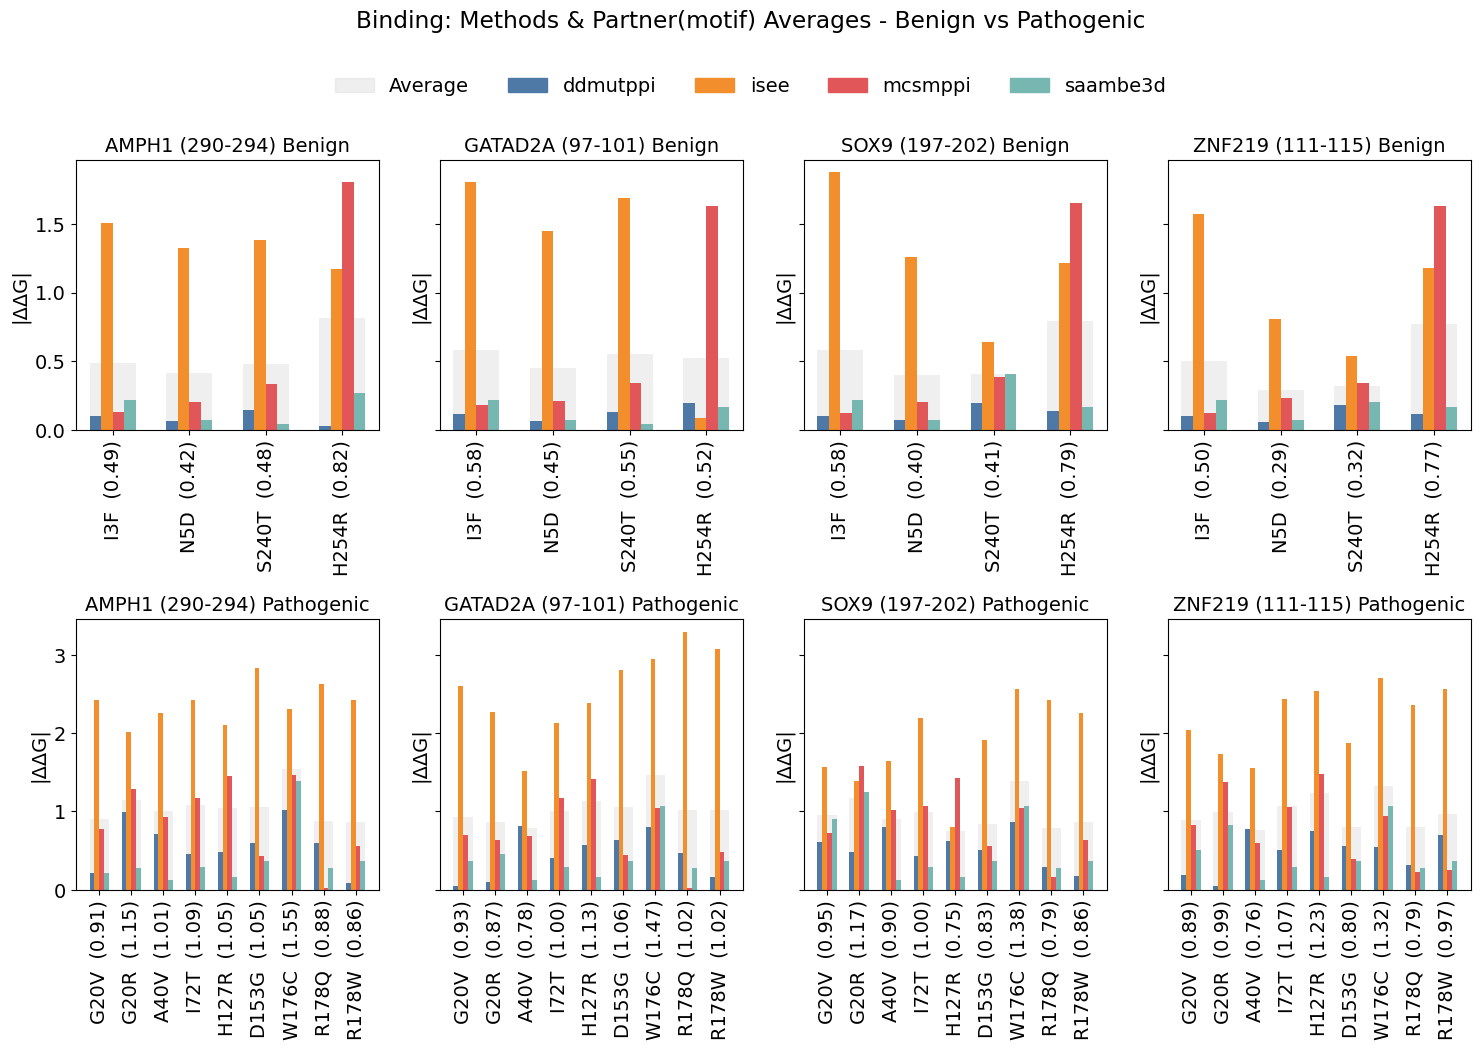

In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Turn off all grids
plt.rcParams.update({'axes.grid': False})


def configure_figure(fig,
                     top_title: str,
                     legend_handles: list,
                     legend_labels: list,
                     fig_size=(15, 10),
                     font_size=16,
                     title_y=0.95,
                     legend_y=0.90,
                     left=0.05, right=0.98,
                     bottom=0.07, top=0.85,
                     hspace=0.4, wspace=0.3):
    """
    Configure overall figure:
    - fig_size: (width, height) in inches
    - font_size: base font size
    - title_y: y-position of the suptitle
    - legend_y: y-position of the legend
    - left/right/top/bottom: margins
    - hspace/wspace: spacing between subplots
    """
    # set size & font
    fig.set_size_inches(*fig_size)
    plt.rcParams.update({'font.size': font_size})

    # super-title
    fig.suptitle(top_title, fontsize=font_size*1.2, y=title_y)

    # legend just below the title
    fig.legend(
        legend_handles,
        legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, legend_y),
        frameon=False,
        ncol=len(legend_labels)
    )

    # adjust subplot grid
    fig.subplots_adjust(
        left=left,
        right=right,
        top=top,
        bottom=bottom,
        hspace=hspace,
        wspace=wspace
    )


# ─── User parameters: adjust paths and targets ─────────────────────────────────
binding_path = "/project/ealexov/compbio/shamrat/250519_energy/04_binding/analysis/clinvar_1kgp_hector_gaf_final_binding.xlsx"
output_dir   = "/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification"
os.makedirs(output_dir, exist_ok=True)

# Define partners and their consensus motif ranges
targets = {
    "SOX9":    "197-202",
    "AMPH1":   "290-294",
    "GATAD2A": "97-101",
    "ZNF219":  "111-115"
}

# ─── 1. Load & filter data ────────────────────────────────────────────────────
df = pd.read_excel(binding_path, sheet_name="Sheet1")
df = df[df['position'].between(1, 302)]
df = df[df['Germline classification'].isin(['Benign', 'Pathogenic'])].copy()

# ─── 2. Detect ddG columns by partner+motif ──────────────────────────────────
pat = re.compile(
    r'^(ddg_[^_]+_(?P<gene>[^_]+)_(?P<motif>[0-9\-]+)_str)_(?P<method>.+)$'
)
partner_cols = {}
methods = set()
for col in df.columns:
    m = pat.match(col)
    if not m:
        continue
    gene, motif, method = m.group('gene'), m.group('motif'), m.group('method')
    if gene in targets and targets[gene] == motif:
        partner_cols.setdefault(gene, {}).setdefault(method, []).append(col)
        methods.add(method)
# Exclude FoldX
methods = sorted(m for m in methods if 'foldx' not in m.lower())
partners = sorted(partner_cols.keys())

# ─── 3. Compute per-method abs ΔΔG arrays and partner averages ───────────────
benign_methods = {g: {} for g in partners}
patho_methods  = {g: {} for g in partners}
ben_idx  = df.index[df['Germline classification'] == 'Benign']
path_idx = df.index[df['Germline classification'] == 'Pathogenic']

for gene in partners:
    all_cols = [
        col
        for meth in methods
        for col in partner_cols[gene].get(meth, [])
    ]
    df[f"avg_{gene}"] = df[all_cols].abs().mean(axis=1)

    for method in methods:
        cols = partner_cols[gene].get(method, [])
        if cols:
            vals = df[cols].abs().mean(axis=1)
            benign_methods[gene][method] = vals.loc[ben_idx].values
            patho_methods[gene][method]  = vals.loc[path_idx].values
        else:
            benign_methods[gene][method] = np.array([])
            patho_methods[gene][method]  = np.array([])

# ─── 4. Plotting ──────────────────────────────────────────────────────────────
colors    = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']
avg_color = '#CCCCCC'
width     = 0.15

# create subplots
fig, axes = plt.subplots(2, len(partners), sharey='row')

for row, (group, methods_dict, idx) in enumerate([
    ('Benign',    benign_methods, ben_idx),
    ('Pathogenic', patho_methods, path_idx)
]):
    for col_i, gene in enumerate(partners):
        ax = axes[row, col_i]

        # --- order by ascending 'position' ---
        group_pos = df.loc[idx, 'position'].values
        order     = np.argsort(group_pos)
        muts      = df.loc[idx, 'mutation'].values[order]
        avg_vals  = df.loc[idx, f"avg_{gene}"].values[order]
        vals      = np.vstack([methods_dict[gene][m] for m in methods])[:, order]
        # ------------------------------------

        x = np.arange(len(muts))

        # average background bars
        ax.bar(x, avg_vals, width*len(methods), color=avg_color, alpha=0.3, zorder=1)
        # per-method bars
        for i, m in enumerate(methods):
            ax.bar(
                x + (i - (len(methods)-1)/2) * width,
                vals[i],
                width,
                color=colors[i],
                zorder=2
            )

        # x-axis labels: mutation plus avg on one line
        labels = [f"{mut}  ({avg_vals[i]:.2f})" for i, mut in enumerate(muts)]
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=90, ha='center')

        # subplot title & y-label
        ax.set_title(f"{gene} ({targets[gene]}) {group}", fontsize=14)
        ax.set_ylabel('|ΔΔG|')

# prepare legend
handles = [Patch(color=avg_color, alpha=0.3)] + [Patch(color=c) for c in colors[:len(methods)]]
labels  = ['Average'] + methods

# apply overall configuration
configure_figure(
    fig,
    top_title='Binding: Methods & Partner(motif) Averages - Benign vs Pathogenic',
    legend_handles=handles,
    legend_labels=labels,
    fig_size=(15, 10),
    font_size=14,
    title_y=0.95,
    legend_y=0.90,
    left=0.05,
    right=0.98,
    bottom=0.07,
    top=0.80,
    hspace=0.7,
    wspace=0.2
)

# save and show
out_png = os.path.join(output_dir, "binding_methods_partner_motif_averages.png")
plt.savefig(out_png, dpi=300, bbox_inches='tight')
plt.show()


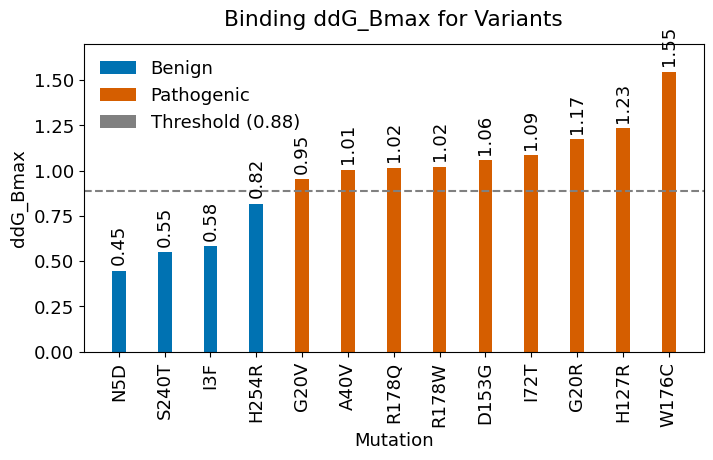

In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ─── Style config & helpers ────────────────────────────────────────────────────
class StyleConfig:
    def __init__(self):
        self.base_fontsize   = 13
        self.annot_fontsize  = 13
        self.legend_fontsize = 13
        self.title_pad       = 13
        self.annot_offset    = 0.02
        self.bar_alpha       = 0.3
        self.bar_width       = 0.3
        self.figsize         = (8, 4)
        self.dpi             = 300
        self.y_headroom      = 1.1

def apply_global_style(cfg):
    plt.rcParams.update({'font.size': cfg.base_fontsize, 'axes.grid': False})

def annotate_bars(ax, xs, heights, cfg):
    top = max(heights)
    for x, h in zip(xs, heights):
        ax.text(
            x, h + top * cfg.annot_offset,
            f"{h:.2f}", ha='center', va='bottom',
            rotation=90, fontsize=cfg.annot_fontsize, clip_on=False
        )

def finalize_axes(ax, ytops, cfg):
    ax.set_ylim(0, max(ytops) * cfg.y_headroom)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

def plot_threshold_panel(ax, df, cfg):
    # sort by ddG_Bmax
    sub = df[df['Germline classification'].isin(['Benign','Pathogenic'])]
    order = np.argsort(sub['ddG_Bmax'].values)
    muts = sub['mutation'].values[order]
    vals = sub['ddG_Bmax'].values[order]
    grps = sub['Germline classification'].values[order]

    # compute threshold
    thr = (sub[sub['Germline classification']=='Benign']['ddG_Bmax'].max() +
           sub[sub['Germline classification']=='Pathogenic']['ddG_Bmax'].min()) / 2

    # bar colors
    cmap = {'Benign':'#0072B2','Pathogenic':'#D55E00'}
    colors = [cmap[g] for g in grps]

    # bars
    x = np.arange(len(muts))
    bars = ax.bar(x, vals, cfg.bar_width, color=colors)

    # threshold line (no label here)
    ax.axhline(thr, color='gray', linestyle='--')

    # annotate
    annotate_bars(ax, x, vals, cfg)

    # labels and title
    ax.set_xticks(x)
    ax.set_xticklabels(muts)
    ax.set_xlabel('Mutation')
    ax.set_ylabel('ddG_Bmax')
    ax.set_title('Binding ddG_Bmax for Variants', loc='center', pad=cfg.title_pad)

    # legend patches (including threshold with label)
    patches = [
        Patch(facecolor='#0072B2', label='Benign'),
        Patch(facecolor='#D55E00', label='Pathogenic'),
        Patch(facecolor='gray', label=f'Threshold ({thr:.2f})')
    ]
    ax.legend(handles=patches, loc='upper left', frameon=False,
              fontsize=cfg.legend_fontsize)

    # adjust y‐axis limits and xtick style
    finalize_axes(ax, list(vals) + [thr], cfg)

# ─── Main: load data & compute ddG_Bmax ────────────────────────────────────────
cfg = StyleConfig()
apply_global_style(cfg)

binding_path = "/project/ealexov/compbio/shamrat/250519_energy/04_binding/analysis/clinvar_1kgp_hector_gaf_final_binding.xlsx"
output_dir   = "/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification"
os.makedirs(output_dir, exist_ok=True)

# define motifs
targets = {
    "SOX9":    "197-202",
    "AMPH1":   "290-294",
    "GATAD2A": "97-101",
    "ZNF219":  "111-115"
}

# load & filter
df = pd.read_excel(binding_path, sheet_name="Sheet1")
df = df[df['position'].between(1, 302)]
df = df[df['Germline classification'].isin(['Benign','Pathogenic'])].copy()

# detect ddG columns for each partner+motif
pat = re.compile(r'^(ddg_[^_]+_(?P<gene>[^_]+)_(?P<motif>[0-9\-]+)_str)_(?P<method>.+)$')
partner_cols, methods = {}, set()
for col in df.columns:
    m = pat.match(col)
    if m and m.group('gene') in targets and targets[m.group('gene')]==m.group('motif'):
        partner_cols.setdefault(m.group('gene'), {}).setdefault(m.group('method'), []).append(col)
        methods.add(m.group('method'))
methods = sorted([m for m in methods if 'foldx' not in m.lower()])

# compute avg_{gene} and global ddG_Bmax
for g in targets:
    cols = [c for meth in methods for c in partner_cols.get(g, {}).get(meth, [])]
    df[f"avg_{g}"] = df[cols].abs().mean(axis=1)
df['ddG_Bmax'] = df[[f"avg_{g}" for g in targets]].max(axis=1)

# ─── Plot single threshold panel ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=cfg.figsize)
plot_threshold_panel(ax, df, cfg)

# save & show
out_png = os.path.join(output_dir, "binding_ddg_Bmax_threshold_styled.png")
fig.savefig(out_png, dpi=cfg.dpi, bbox_inches='tight')
plt.show()


In [7]:
# — after you’ve built df, targets, benign_methods, patho_methods, methods, partners and computed df['ddG_Bmax'] —
# (this is the script from “binding_ddg_Bmax_threshold_styled.png”)

# 1. Threshold:
ben_max_b  = df.loc[df['Germline classification']=='Benign',  'ddG_Bmax'].max()
path_min_b = df.loc[df['Germline classification']=='Pathogenic','ddG_Bmax'].min()
thr_b      = (ben_max_b + path_min_b) / 2

# 2. Print counts & threshold:
print("---- Binding ddG_Bmax Summary ----")
print(f"Total Benign variants:    {df['Germline classification'].eq('Benign').sum()}")
print(f"Total Pathogenic variants: {df['Germline classification'].eq('Pathogenic').sum()}")
print(f"Binding ddG_Bmax threshold: {thr_b:.2f}\n")

# 3. Per-variant table:
print("Mutation\tPos\tddG_Bmax\t" + "\t".join(f"avg_{g}" for g in targets))
for _, row in df.sort_values("ddG_Bmax").iterrows():
    mutation = row["mutation"]
    pos      = int(row["position"])
    bmax     = row["ddG_Bmax"]
    avgs     = [row[f"avg_{g}"] for g in targets]
    line = "\t".join([mutation, str(pos), f"{bmax:.2f}"] + [f"{v:.2f}" for v in avgs])
    print(line)
print()

# 4. Per-method means for the multi-panel (binding by partner):
for group_name, methods_dict in [("Benign", benign_methods), ("Pathogenic", patho_methods)]:
    print(f"---- {group_name} variants per-method means ----")
    print("Partner\tMethod\tMean |ΔΔG|")
    for gene in partners:
        for method in methods:
            arr = methods_dict[gene][method]
            if arr.size:
                print(f"{gene}\t{method}\t{arr.mean():.2f}")
    print()


---- Binding ddG_Bmax Summary ----
Total Benign variants:    4
Total Pathogenic variants: 9
Binding ddG_Bmax threshold: 0.88

Mutation	Pos	ddG_Bmax	avg_SOX9	avg_AMPH1	avg_GATAD2A	avg_ZNF219
N5D	5	0.45	0.40	0.42	0.45	0.29
S240T	240	0.55	0.41	0.48	0.55	0.32
I3F	3	0.58	0.58	0.49	0.58	0.50
H254R	254	0.82	0.79	0.82	0.52	0.77
G20V	20	0.95	0.95	0.91	0.93	0.89
A40V	40	1.01	0.90	1.01	0.78	0.76
R178Q	178	1.02	0.79	0.88	1.02	0.79
R178W	178	1.02	0.86	0.86	1.02	0.97
D153G	153	1.06	0.83	1.05	1.06	0.80
I72T	72	1.09	1.00	1.09	1.00	1.07
G20R	20	1.17	1.17	1.15	0.87	0.99
H127R	127	1.23	0.75	1.05	1.13	1.23
W176C	176	1.55	1.38	1.55	1.47	1.32

---- Benign variants per-method means ----
Partner	Method	Mean |ΔΔG|
AMPH1	ddmutppi	0.09
AMPH1	isee	1.35
AMPH1	mcsmppi	0.62
AMPH1	saambe3d	0.15
GATAD2A	ddmutppi	0.13
GATAD2A	isee	1.26
GATAD2A	mcsmppi	0.59
GATAD2A	saambe3d	0.12
SOX9	ddmutppi	0.13
SOX9	isee	1.25
SOX9	mcsmppi	0.59
SOX9	saambe3d	0.22
ZNF219	ddmutppi	0.11
ZNF219	isee	1.02
ZNF219	mcsmppi	0.58
ZNF219	saambe3

## 1.2 plotting part2: Reclassification

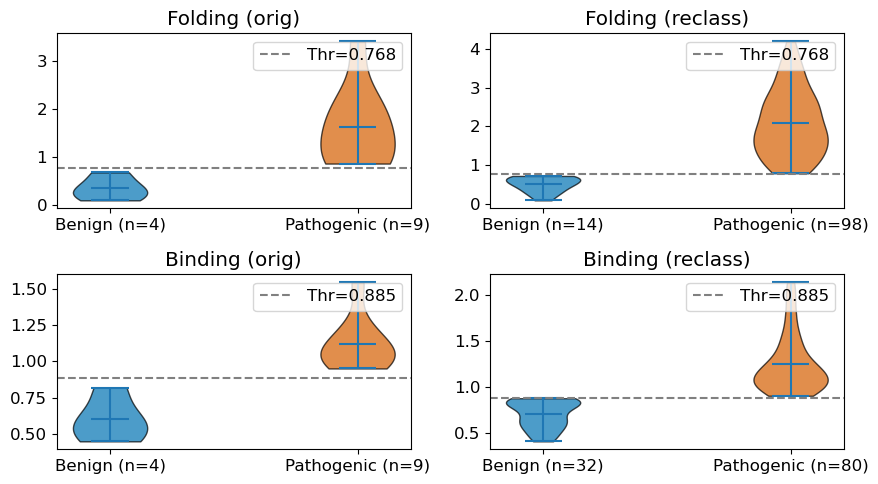

/local_scratch/slurm.3946746/ipykernel_2102645/307297776.py:127: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


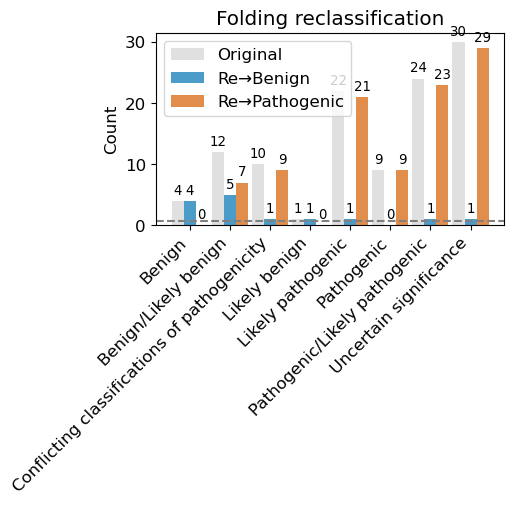

/local_scratch/slurm.3946746/ipykernel_2102645/307297776.py:127: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


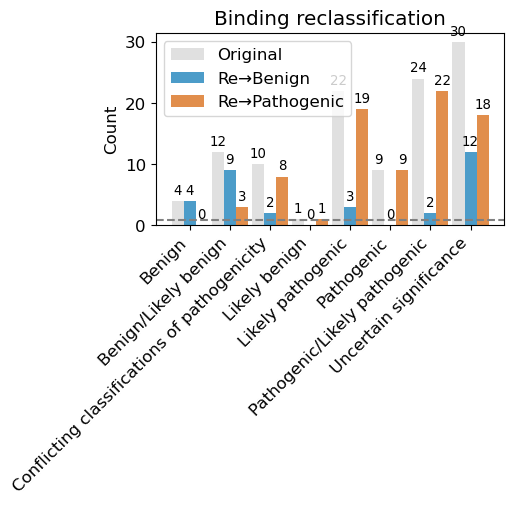

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def plot_ddg_distributions(folding_path, binding_path,
                           fig_width=12, fig_height=10,
                           font_size=12, violin_width=0.7):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    plt.rcParams.update({'font.size': font_size})

    # ——— 1. Folding data ———
    df_fold = pd.read_excel(folding_path)
    df_fold = df_fold[df_fold['position'].between(1, 302)]
    str_cols = [c for c in df_fold.columns if c.endswith('_str') and 'foldx' not in c.lower()]
    df_fold['ddG_Fmax'] = df_fold[str_cols].abs().max(axis=1)

    benign_fold = df_fold[df_fold['Germline classification']=='Benign']
    path_fold   = df_fold[df_fold['Germline classification']=='Pathogenic']
    max_ben_f = benign_fold['ddG_Fmax'].max()
    min_pat_f = path_fold['ddG_Fmax'].min()
    threshold_f = (max_ben_f + min_pat_f) / 2

    # reclassify
    df_fold['Reclass_fold'] = df_fold['Germline classification']
    mask_unc = ~df_fold['Germline classification'].isin(['Benign','Pathogenic'])
    df_fold.loc[mask_unc & (df_fold['ddG_Fmax']>=threshold_f), 'Reclass_fold'] = 'Pathogenic'
    df_fold.loc[mask_unc & (df_fold['ddG_Fmax']< threshold_f), 'Reclass_fold'] = 'Benign'

    counts_f = {
        'orig_ben': len(benign_fold),
        'orig_path': len(path_fold),
        'pred_ben': (df_fold['Reclass_fold']=='Benign').sum(),
        'pred_path': (df_fold['Reclass_fold']=='Pathogenic').sum()
    }

    # ——— 2. Binding data ———
    df_bind = pd.read_excel(binding_path)
    df_bind = df_bind[df_bind['position'].between(1, 302)]
    ddg_cols = [c for c in df_bind.columns if c.startswith('ddg_') and '_str_' in c and 'foldx' not in c.lower()]
    partners = ['SOX9','AMPH1','GATAD2A','ZNF219']
    present = [p for p in partners if any(f"_{p}_" in c for c in ddg_cols)]
    for p in present:
        cols = [c for c in ddg_cols if f"_{p}_" in c]
        df_bind[f"ddG_B_{p}"] = df_bind[cols].abs().mean(axis=1)
    df_bind['ddG_Bmax'] = df_bind[[f"ddG_B_{p}" for p in present]].max(axis=1)

    benign_bind = df_bind[df_bind['Germline classification']=='Benign']
    path_bind   = df_bind[df_bind['Germline classification']=='Pathogenic']
    max_ben_b = benign_bind['ddG_Bmax'].max()
    min_pat_b = path_bind['ddG_Bmax'].min()
    threshold_b = (max_ben_b + min_pat_b) / 2

    df_bind['Reclass_bind'] = df_bind['Germline classification']
    mask_unc_b = ~df_bind['Germline classification'].isin(['Benign','Pathogenic'])
    df_bind.loc[mask_unc_b & (df_bind['ddG_Bmax']>=threshold_b), 'Reclass_bind'] = 'Pathogenic'
    df_bind.loc[mask_unc_b & (df_bind['ddG_Bmax']< threshold_b), 'Reclass_bind'] = 'Benign'

    counts_b = {
        'orig_ben': len(benign_bind),
        'orig_path': len(path_bind),
        'pred_ben': (df_bind['Reclass_bind']=='Benign').sum(),
        'pred_path': (df_bind['Reclass_bind']=='Pathogenic').sum()
    }

    color_map = {'Benign': '#0072B2', 'Pathogenic': '#D55E00'}

    # ——— 3. Violin plots ———
    fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height))
    specs = [
        (axes[0,0], [benign_fold['ddG_Fmax'], path_fold['ddG_Fmax']], "Folding (orig)", threshold_f, counts_f, True),
        (axes[0,1], [df_fold[df_fold['Reclass_fold']=='Benign']['ddG_Fmax'],
                     df_fold[df_fold['Reclass_fold']=='Pathogenic']['ddG_Fmax']],
                     "Folding (reclass)", threshold_f, counts_f, False),
        (axes[1,0], [benign_bind['ddG_Bmax'], path_bind['ddG_Bmax']], "Binding (orig)", threshold_b, counts_b, True),
        (axes[1,1], [df_bind[df_bind['Reclass_bind']=='Benign']['ddG_Bmax'],
                     df_bind[df_bind['Reclass_bind']=='Pathogenic']['ddG_Bmax']],
                     "Binding (reclass)", threshold_b, counts_b, False),
    ]
    for ax, data, title, thr, cnts, is_orig in specs:
        v = ax.violinplot(data, showmeans=True, widths=violin_width)
        for body, col in zip(v['bodies'], [color_map['Benign'], color_map['Pathogenic']]):
            body.set_facecolor(col); body.set_edgecolor('black'); body.set_alpha(0.7)
        ax.axhline(thr, linestyle='--', color='gray', label=f"Thr={thr:.3f}")
        ax.set_xticks([1,2])
        if is_orig:
            ax.set_xticklabels([f"Benign (n={cnts['orig_ben']})",
                                f"Pathogenic (n={cnts['orig_path']})"])
        else:
            ax.set_xticklabels([f"Benign (n={cnts['pred_ben']})",
                                f"Pathogenic (n={cnts['pred_path']})"])
        ax.set_title(title)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # ——— 4. Grouped‐bar reclassification with annotations ———
    def plot_grouped_reclass(df, orig_col, re_col, title, threshold):
        ct = pd.crosstab(df[orig_col], df[re_col])
        idx = ct.index.tolist()
        orig = df[orig_col].value_counts().reindex(idx).fillna(0).values
        re_b = ct.get('Benign', pd.Series(0, index=idx)).values
        re_p = ct.get('Pathogenic', pd.Series(0, index=idx)).values

        x = np.arange(len(idx))
        bw = 0.3

        fig, ax = plt.subplots(figsize=(fig_width/2, fig_height/2))
        bars1 = ax.bar(x - bw, orig, width=bw, color='lightgray',                  label='Original',      alpha=0.7)
        bars2 = ax.bar(x,      re_b,  width=bw, color=color_map['Benign'],         label='Re→Benign',     alpha=0.7)
        bars3 = ax.bar(x + bw, re_p,  width=bw, color=color_map['Pathogenic'],     label='Re→Pathogenic', alpha=0.7)

        ax.axhline(threshold, linestyle='--', color='gray')
        ax.set_xticks(x); ax.set_xticklabels(idx, rotation=45, ha='right')
        ax.set_ylabel("Count"); ax.set_title(f"{title} reclassification")

        # annotate counts on top
        for bars in (bars1, bars2, bars3):
            for bar in bars:
                h = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, h + 0.02*max(orig.max(), re_b.max(), re_p.max()),
                        int(h), ha='center', va='bottom', fontsize=font_size*0.8)

        ax.legend()
        plt.tight_layout()
        plt.show()

    plot_grouped_reclass(df_fold, 'Germline classification', 'Reclass_fold', 'Folding', threshold_f)
    plot_grouped_reclass(df_bind, 'Germline classification', 'Reclass_bind', 'Binding', threshold_b)


# Example usage
plot_ddg_distributions(
    "/project/ealexov/compbio/shamrat/250519_energy/02_folding/01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx",
    "/project/ealexov/compbio/shamrat/250519_energy/04_binding/clinvar_1kgp_hector_gaf_final_binding_znf219_111_only.xlsx",
    fig_width=9, fig_height=5,
    font_size=12, violin_width=0.3
)


## Variant Reclassification based on DDG_folding and DDG_binding

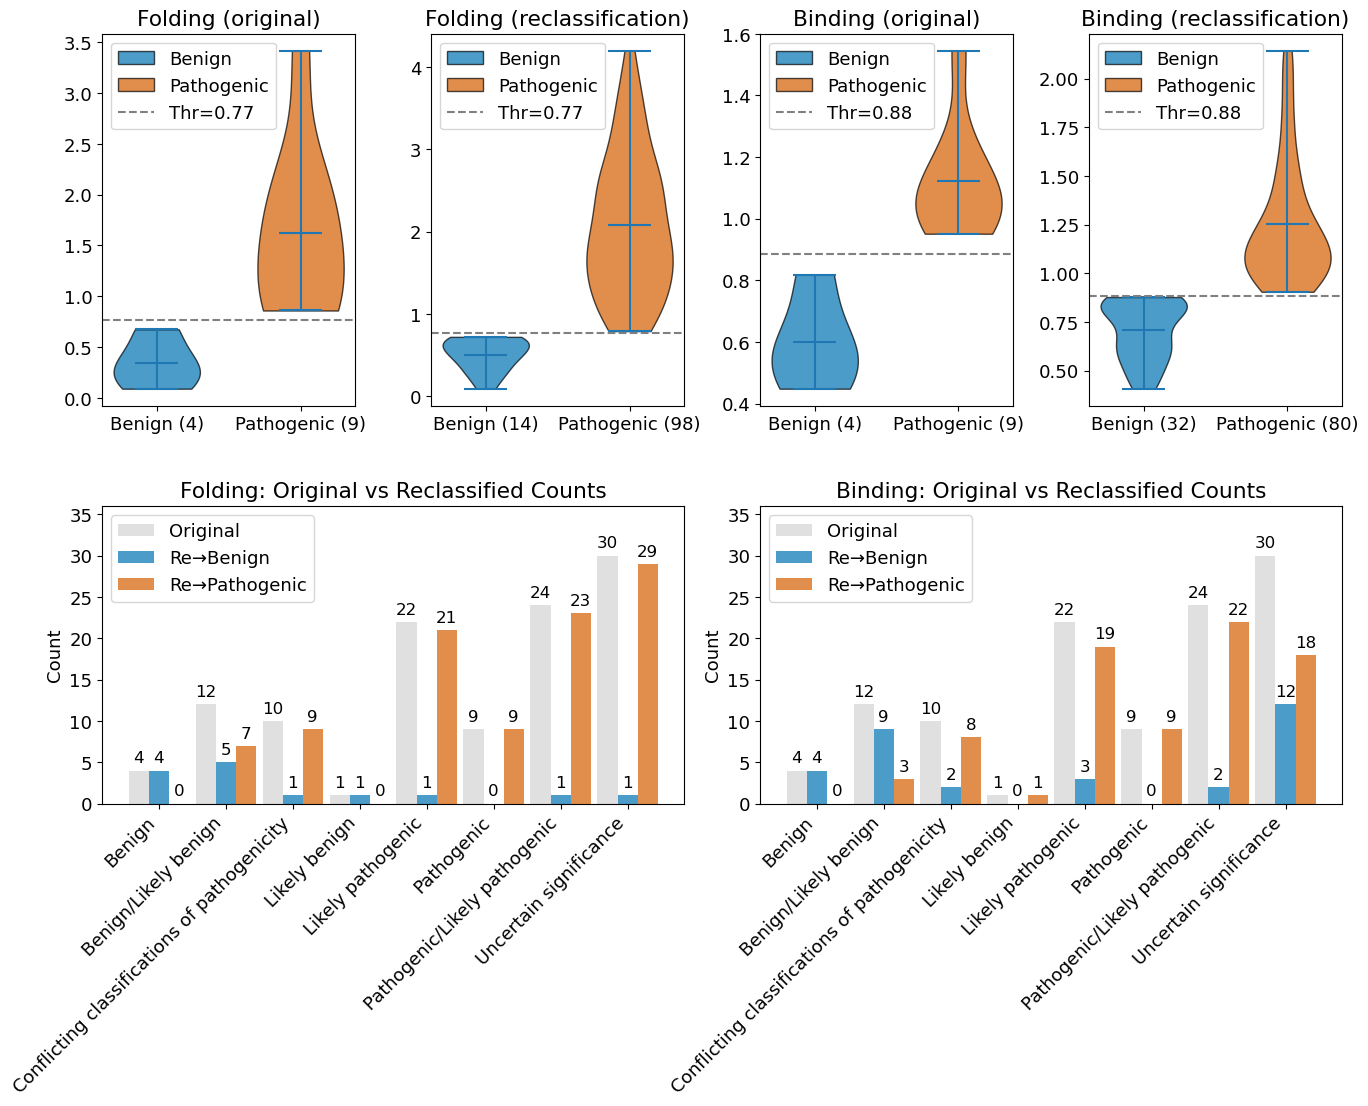

In [95]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ── Helper to tweak overall cosmetics ────────────────────────────────────────
def set_plot_cosmetics(fig,
                       fig_width=16, fig_height=10,
                       font_size=12, show_grid=False,
                       hspace=0.4, wspace=0.3):
    fig.set_size_inches(fig_width, fig_height)
    plt.rcParams.update({
        'font.size': font_size,
        'axes.grid': show_grid
    })
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

# ── Main plotting function ───────────────────────────────────────────────────
def plot_fold_bind_full(folding_path, binding_path, save_path=None,
                        # cosmetics:
                        fig_width=16, fig_height=10,
                        font_size=12, show_grid=False,
                        hspace=0.4, wspace=0.3,
                        violin_width=0.6, bar_width=0.3,
                        bar_label_font_size=None):
    """
    - save_path: if provided, saves figure to this full path.
    - bar_label_font_size: numeric font size for bar value labels (default = 0.8 * font_size).
    """
    if bar_label_font_size is None:
        bar_label_font_size = font_size * 0.8

    os.makedirs(os.path.dirname(save_path), exist_ok=True) if save_path else None

    # ── 1. Data prep ──────────────────────────────────────────────────────────
    df_fold = pd.read_excel(folding_path)
    df_fold = df_fold[df_fold['position'].between(1, 302)]
    str_cols = [c for c in df_fold.columns if c.endswith('_str') and 'foldx' not in c.lower()]
    df_fold['ddG_Fmax'] = df_fold[str_cols].abs().max(axis=1)
    ben_f = df_fold[df_fold['Germline classification']=='Benign']['ddG_Fmax']
    pat_f = df_fold[df_fold['Germline classification']=='Pathogenic']['ddG_Fmax']
    thr_f = (ben_f.max() + pat_f.min()) / 2
    df_fold['Reclass_fold'] = df_fold['Germline classification']
    mask_unc = ~df_fold['Germline classification'].isin(['Benign','Pathogenic'])
    df_fold.loc[mask_unc & (df_fold['ddG_Fmax']>=thr_f), 'Reclass_fold'] = 'Pathogenic'
    df_fold.loc[mask_unc & (df_fold['ddG_Fmax']< thr_f),  'Reclass_fold'] = 'Benign'
    reben_f = df_fold[df_fold['Reclass_fold']=='Benign']['ddG_Fmax']
    repat_f = df_fold[df_fold['Reclass_fold']=='Pathogenic']['ddG_Fmax']

    df_bind = pd.read_excel(binding_path)
    df_bind = df_bind[df_bind['position'].between(1, 302)]
    ddg_cols = [c for c in df_bind.columns if c.startswith('ddg_') and '_str_' in c and 'foldx' not in c.lower()]
    targets = {
        "SOX9":    "197-202",
        "AMPH1":   "290-294",
        "GATAD2A": "97-101",
        "ZNF219":  "111-115"
    }
    for gene, motif in targets.items():
        cols = [c for c in ddg_cols if f"_{gene}_" in c and f"_{motif}_" in c]
        if cols:
            df_bind[f"ddG_B_{gene}"] = df_bind[cols].abs().mean(axis=1)
    ddgB_cols = [f"ddG_B_{g}" for g in targets if f"ddG_B_{g}" in df_bind]
    df_bind['ddG_Bmax'] = df_bind[ddgB_cols].max(axis=1)
    ben_b = df_bind[df_bind['Germline classification']=='Benign']['ddG_Bmax']
    pat_b = df_bind[df_bind['Germline classification']=='Pathogenic']['ddG_Bmax']
    thr_b = (ben_b.max() + pat_b.min()) / 2
    df_bind['Reclass_bind'] = df_bind['Germline classification']
    mask_unc = ~df_bind['Germline classification'].isin(['Benign','Pathogenic'])
    df_bind.loc[mask_unc & (df_bind['ddG_Bmax']>=thr_b), 'Reclass_bind'] = 'Pathogenic'
    df_bind.loc[mask_unc & (df_bind['ddG_Bmax']< thr_b),  'Reclass_bind'] = 'Benign'
    reben_b = df_bind[df_bind['Reclass_bind']=='Benign']['ddG_Bmax']
    repat_b = df_bind[df_bind['Reclass_bind']=='Pathogenic']['ddG_Bmax']

    color_map = {'Benign':'#0072B2','Pathogenic':'#D55E00'}

    # ── 2. Layout & cosmetics ─────────────────────────────────────────────────
    fig = plt.figure()
    set_plot_cosmetics(fig, fig_width, fig_height, font_size, show_grid, hspace, wspace)
    gs = GridSpec(2, 4, figure=fig, height_ratios=[1,0.8], width_ratios=[1,1,1,1])

    # Row 0: 4 violins
    violins = [
        (ben_f, pat_f, "Folding (original)", thr_f),
        (reben_f, repat_f, "Folding (reclassification)", thr_f),
        (ben_b, pat_b, "Binding (original)", thr_b),
        (reben_b, repat_b, "Binding (reclassification)", thr_b),
    ]
    for i, (d0, d1, title, thr) in enumerate(violins):
        ax = fig.add_subplot(gs[0, i])
        v = ax.violinplot([d0, d1], showmeans=True, widths=violin_width)
        for body, grp in zip(v['bodies'], ['Benign','Pathogenic']):
            body.set_facecolor(color_map[grp]); body.set_edgecolor('black'); body.set_alpha(0.7)
        ax.axhline(thr, linestyle='--', color='gray')
        ax.set_xticks([1,2])
        ax.set_xticklabels([f"Benign ({len(d0)})", f"Pathogenic ({len(d1)})"])
        ax.set_title(title)
        thr_handle = Line2D([0],[0], color='gray', linestyle='--', label=f"Thr={thr:.2f}")
        handles = [
            Patch(facecolor=color_map['Benign'], edgecolor='black', alpha=0.7, label='Benign'),
            Patch(facecolor=color_map['Pathogenic'], edgecolor='black', alpha=0.7, label='Pathogenic'),
            thr_handle
        ]
        ax.legend(handles=handles, loc='upper left')

    # Row 1: bar charts
    def plot_grouped(ax, df, orig, rec, title):
        ct = pd.crosstab(df[orig], df[rec])
        idx = ct.index.tolist()
        orig_cnt = df[orig].value_counts().reindex(idx).fillna(0).values
        rb = ct.get('Benign', pd.Series(0,index=idx)).values
        rp = ct.get('Pathogenic', pd.Series(0,index=idx)).values
        x = np.arange(len(idx))

        bo = ax.bar(x-bar_width, orig_cnt, width=bar_width, color='lightgray', label='Original', alpha=0.7)
        bb = ax.bar(x, rb, width=bar_width, color=color_map['Benign'], alpha=0.7, label='Re→Benign')
        bp = ax.bar(x+bar_width, rp, width=bar_width, color=color_map['Pathogenic'], alpha=0.7, label='Re→Pathogenic')

        ymax = max(orig_cnt.max(), rb.max(), rp.max())
        ax.set_ylim(0, ymax * 1.2)
        ax.set_xticks(x)
        ax.set_xticklabels(idx, rotation=45, ha='right')
        ax.set_ylabel("Count")
        ax.set_title(f"{title}: Original vs Reclassified Counts")

        for bar in list(bo)+list(bb)+list(bp):
            h = bar.get_height()
            ax.text(bar.get_x()+bar.get_width()/2,
                    h + ymax*0.02, int(h),
                    ha='center', va='bottom',
                    fontsize=bar_label_font_size)
        ax.legend()

    ax1 = fig.add_subplot(gs[1, 0:2])
    plot_grouped(ax1, df_fold, 'Germline classification', 'Reclass_fold', 'Folding')
    ax2 = fig.add_subplot(gs[1, 2:4])
    plot_grouped(ax2, df_bind, 'Germline classification', 'Reclass_bind', 'Binding')

    # ── 3. Save and show ───────────────────────────────────────────────────────
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
if __name__ == "__main__":
    plot_fold_bind_full(
        folding_path="/project/ealexov/compbio/shamrat/250519_energy/02_folding/"
                     "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx",
        binding_path="/project/ealexov/compbio/shamrat/250519_energy/04_binding/"
                     "clinvar_1kgp_hector_gaf_final_binding.xlsx",
        save_path="/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification/"
                  "fold_bind_full.png",
        fig_width=16,
        fig_height=10,
        font_size=13,
        show_grid=False,
        hspace=0.3,
        wspace=0.3,
        violin_width=0.6,
        bar_width=0.3,
        bar_label_font_size=12
    )
